# Dinámica de Precios Inmobiliarios en CDMX ante COVID-19: Un Análisis Causal

In [69]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

In [70]:
# read parquet
df_properties = pd.read_parquet("../data/properties_predicted.parquet")

In [71]:
column_names = df_properties.columns.tolist()
print(column_names)

['observation_id', 'y', 'y_pred', 'y_fitted', 'y_pred_fitted', 'set', 'half_bathrooms', 'full_bathrooms', 'property_class_more_common_in_area', 'neighborhood', 'constructor', 'zip_code', 'age_in_months', 'parking_lots', 'valuation_date', 'potable_water_service_id', 'lighting_service_id', 'sidewalk_id', 'project_quality_id', 'property_class_id', 'conservation_status_id', 'controller_id', 'elevator_service_id', 'state_id', 'equipment_id', 'curb_id', 'infrastructure_service_id', 'road_materials_id', 'municipality_id', 'grantor_id', 'urban_proximity_id', 'water_collection_service_id', 'electrical_supply_service_id', 'telephone_service_supply_id', 'property_type_id', 'public_transportation_service_id', 'valuation_unit_id', 'valuation_professional_id', 'level', 'total_levels', 'purpose_of_appraisal', 'bedrooms', 'built_area', 'saleable_area', 'land_area', 'rentable_units', 'rentable_units_subject_property', 'current_use', 'market_price', 'price', 'built_price', 'land_price', 'access_routes',

In [72]:
# Cargar el archivo parquet con los datos ya predichos
file_path = '../data/properties_predicted.parquet'
df = pd.read_parquet(file_path)

# Asegurar que la columna de fecha esté en formato datetime
if not pd.api.types.is_datetime64_any_dtype(df['valuation_date']):
    df['valuation_date'] = pd.to_datetime(df['valuation_date'])

# Calcular el premio de precio como diferencia logarítmica
# Se asume que 'y' y 'y_pred' están en escala original (precio por m2)
df['log_y'] = np.log(df['y'])
df['log_y_pred'] = np.log(df['y_pred'])
df['price_premium'] = df['log_y'] - df['log_y_pred']

# Crear columna de periodo mensual para agregación
df['period'] = df['valuation_date'].dt.to_period('M')

# Agregar por hexágono y periodo
causal_series_hex = df.groupby(['hex_id', 'period']).agg(
    avg_price_premium = ('price_premium', 'mean'),
    volume = ('y', 'count')
).reset_index()

# Convertir periodo a timestamp para compatibilidad
causal_series_hex['period'] = causal_series_hex['period'].dt.to_timestamp()

# Guardar el resultado para análisis posterior
causal_series_hex.to_csv('series_causales_por_hexagono.csv', index=False)

# Mostrar resumen
print(causal_series_hex.head())
print(f"Número total de hexágonos únicos: {causal_series_hex['hex_id'].nunique()}")

            hex_id     period  avg_price_premium  volume
0  8929a4c0003ffff 2022-09-01          -0.121905       1
1  8929a4c0007ffff 2022-12-01           0.057257       2
2  8929a4c000bffff 2022-09-01          -0.264164       1
3  8929a4c000bffff 2023-03-01           0.166451       1
4  8929a4c0013ffff 2022-06-01          -0.123165       1
Número total de hexágonos únicos: 78810


In [76]:
df['state_id'] = df['state_id'].astype(int)

In [77]:
# 1. Diccionario de coordenadas de capitales
capitales = {
    1: {'nombre': 'Aguascalientes', 'lon': -102.296, 'lat': 21.8823},
    2: {'nombre': 'Baja California', 'lon': -116.5964, 'lat': 32.525},
    3: {'nombre': 'Baja California Sur', 'lon': -110.3167, 'lat': 24.1426},
    4: {'nombre': 'Campeche', 'lon': -90.5305, 'lat': 19.8452},
    5: {'nombre': 'Coahuila', 'lon': -101.0063, 'lat': 25.4383},
    6: {'nombre': 'Colima', 'lon': -103.7271, 'lat': 19.2433},
    7: {'nombre': 'Chiapas', 'lon': -93.1471, 'lat': 16.7531},
    8: {'nombre': 'Chihuahua', 'lon': -106.0889, 'lat': 28.6353},
    9: {'nombre': 'CDMX', 'lon': -99.1332, 'lat': 19.4326},
    10: {'nombre': 'Durango', 'lon': -104.6586, 'lat': 24.0277},
    11: {'nombre': 'Guanajuato', 'lon': -101.2574, 'lat': 21.0181},
    12: {'nombre': 'Guerrero', 'lon': -99.9018, 'lat': 17.5532},
    13: {'nombre': 'Hidalgo', 'lon': -98.7303, 'lat': 20.1011},
    14: {'nombre': 'Jalisco', 'lon': -103.3496, 'lat': 20.6597},
    15: {'nombre': 'México', 'lon': -99.627, 'lat': 19.2922},
    16: {'nombre': 'Michoacán', 'lon': -101.195, 'lat': 19.7008},
    17: {'nombre': 'Morelos', 'lon': -99.2345, 'lat': 18.9186},
    18: {'nombre': 'Nayarit', 'lon': -104.8957, 'lat': 21.5058},
    19: {'nombre': 'Nuevo León', 'lon': -100.3161, 'lat': 25.6866},
    20: {'nombre': 'Oaxaca', 'lon': -96.7266, 'lat': 17.0732},
    21: {'nombre': 'Puebla', 'lon': -98.2063, 'lat': 19.0414},
    22: {'nombre': 'Querétaro', 'lon': -100.3899, 'lat': 20.5888},
    23: {'nombre': 'Quintana Roo', 'lon': -86.8475, 'lat': 21.1619},
    24: {'nombre': 'San Luis Potosí', 'lon': -101.0063, 'lat': 22.1565},
    25: {'nombre': 'Sinaloa', 'lon': -107.3940, 'lat': 24.8091},
    26: {'nombre': 'Sonora', 'lon': -110.9542, 'lat': 29.0729},
    27: {'nombre': 'Tabasco', 'lon': -92.9361, 'lat': 17.9895},
    28: {'nombre': 'Tamaulipas', 'lon': -99.1332, 'lat': 23.7369},
    29: {'nombre': 'Tlaxcala', 'lon': -98.2319, 'lat': 19.3182},
    30: {'nombre': 'Veracruz', 'lon': -96.1342, 'lat': 19.1738},
    31: {'nombre': 'Yucatán', 'lon': -89.6227, 'lat': 20.9674},
    32: {'nombre': 'Zacatecas', 'lon': -102.5832, 'lat': 22.7709}
}

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Vectorized haversine function for arrays.
    """
    R = 6371.0  # Radio de la tierra en km
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Aplica la distancia al centro de cada estado
df['dist_centro_km'] = df.apply(
    lambda row: haversine_np(
        row['longitude'], row['latitude'],
        capitales.get(row['state_id'], {'lon': np.nan, 'lat': np.nan})['lon'],
        capitales.get(row['state_id'], {'lon': np.nan, 'lat': np.nan})['lat']
    ),
    axis=1
)

# Segmenta las zonas
df['zona'] = pd.cut(
    df['dist_centro_km'],
    bins=[-np.inf, 6, 12, np.inf],
    labels=['Céntrico', 'Intermedio', 'Periférico']
)

print(df[['state_id', 'dist_centro_km', 'zona']])

         state_id  dist_centro_km        zona
0              14       11.052637  Intermedio
1              28      413.547823  Periférico
2               9        5.087742    Céntrico
3              15       66.640673  Periférico
4              24        8.662873  Intermedio
...           ...             ...         ...
1908478        28      110.590002  Periférico
1908479        15       75.354854  Periférico
1908480         5        7.327483  Intermedio
1908481        15       51.448237  Periférico
1908482        22        8.760370  Intermedio

[1908483 rows x 3 columns]


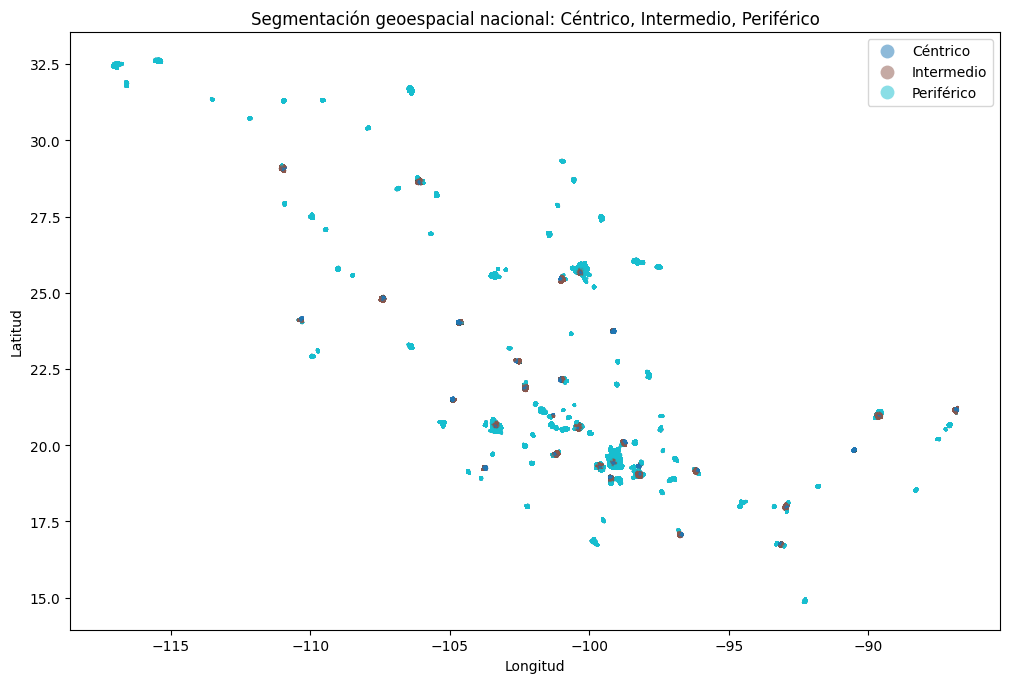

In [78]:
# Si tu DataFrame se llama df:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs='EPSG:4326'
)

fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(column='zona', categorical=True, legend=True, ax=ax, markersize=1, alpha=0.5)
plt.title('Segmentación geoespacial nacional: Céntrico, Intermedio, Periférico')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

### Construcción de las series de tiempo por zona

Agrega el price_premium (o la métrica hedónica ajustada que definiste) por:

* Estado
* Zona (Céntrico, Intermedio, Periférico)
* Periodo (mensual)

Esto te permitirá comparar la dinámica de precios y volumen de transacciones entre zonas y estados.

In [85]:
series_zona_estado = (
    df
    .groupby(['state_id', 'zona', 'period'], observed=True)
    .agg(
        price_premium_mean = ('price_premium', 'mean'),
        volume              = ('price_premium', 'count')
    )
    .reset_index()
)

series_zona_estado.head()

state_id      zona   period  price_premium_mean  volume
0         1  Céntrico  2019-01           -0.001043     258
1         1  Céntrico  2019-02           -0.005588     253
2         1  Céntrico  2019-03            0.003233     276
3         1  Céntrico  2019-04           -0.005376     257
4         1  Céntrico  2019-05            0.001764     271

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

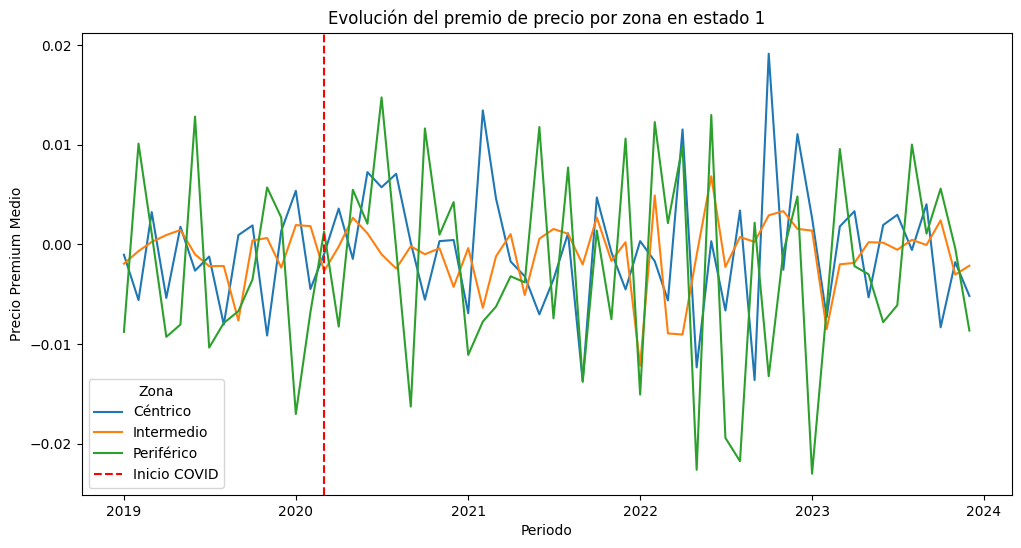

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

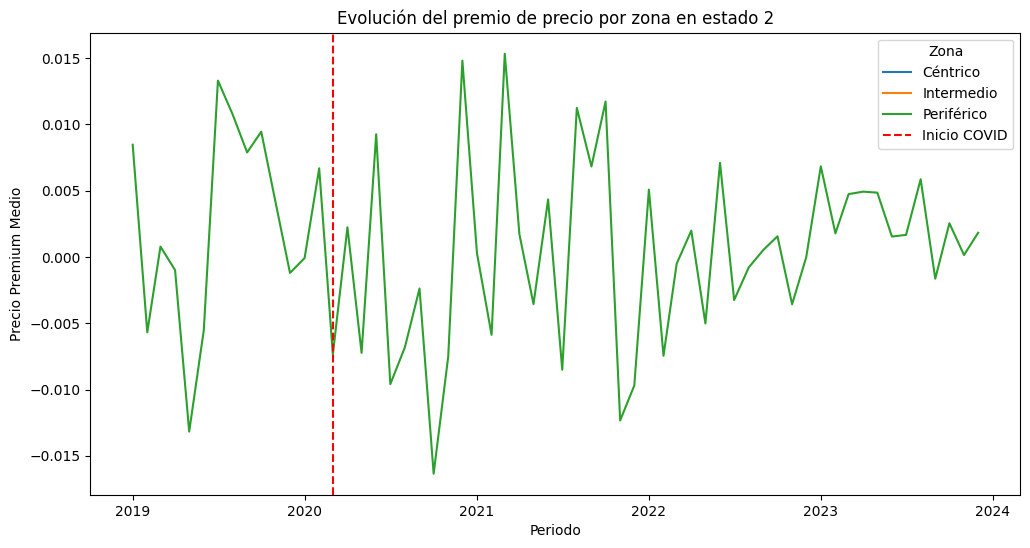

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

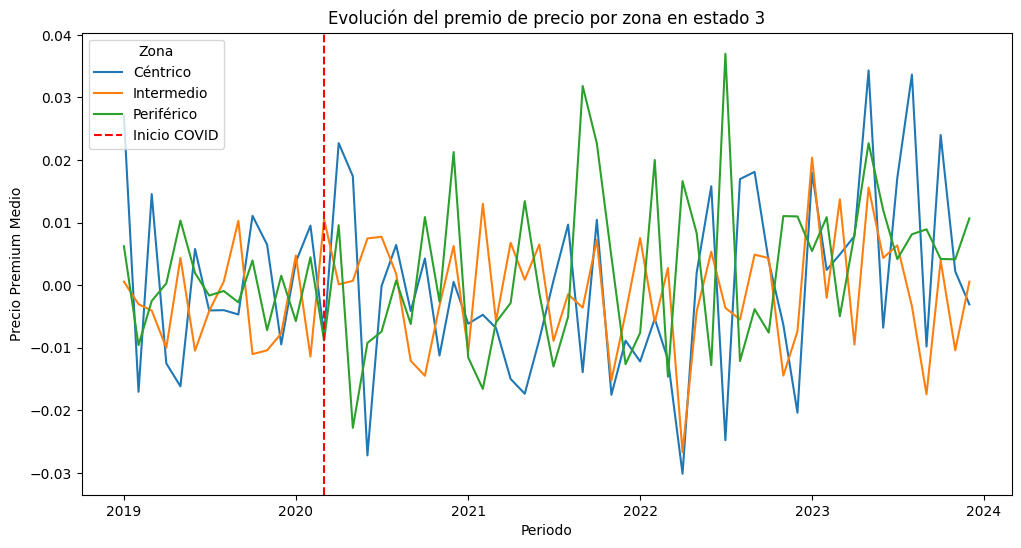

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

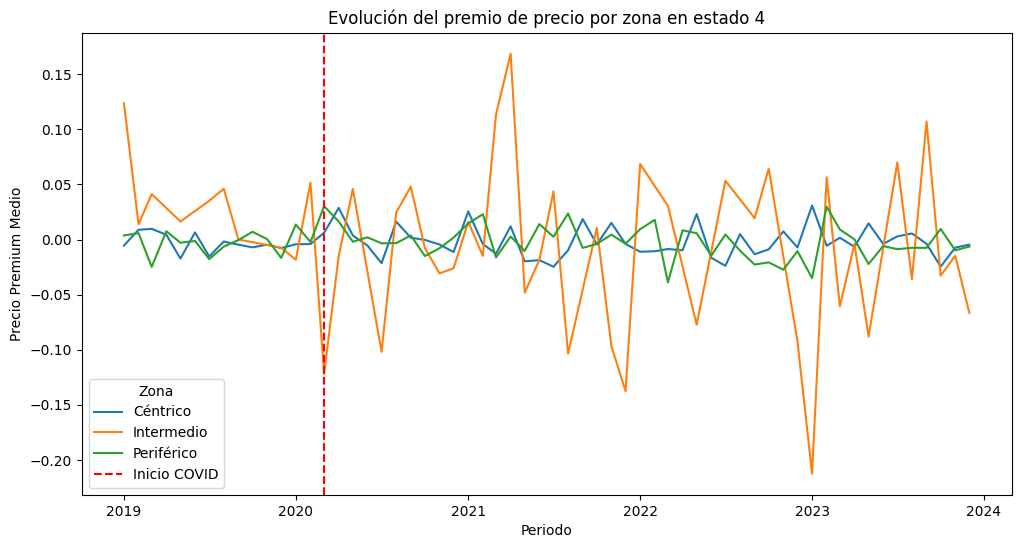

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

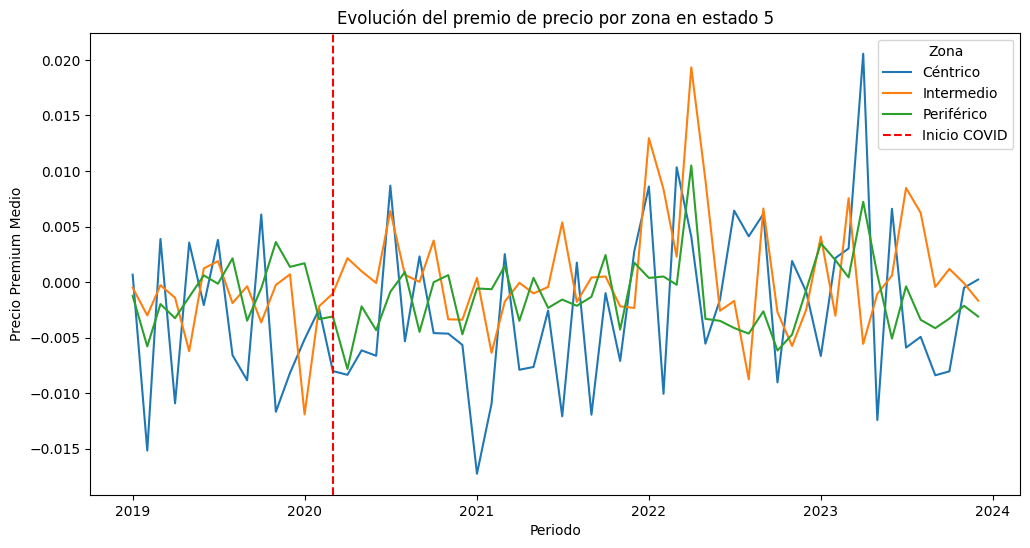

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

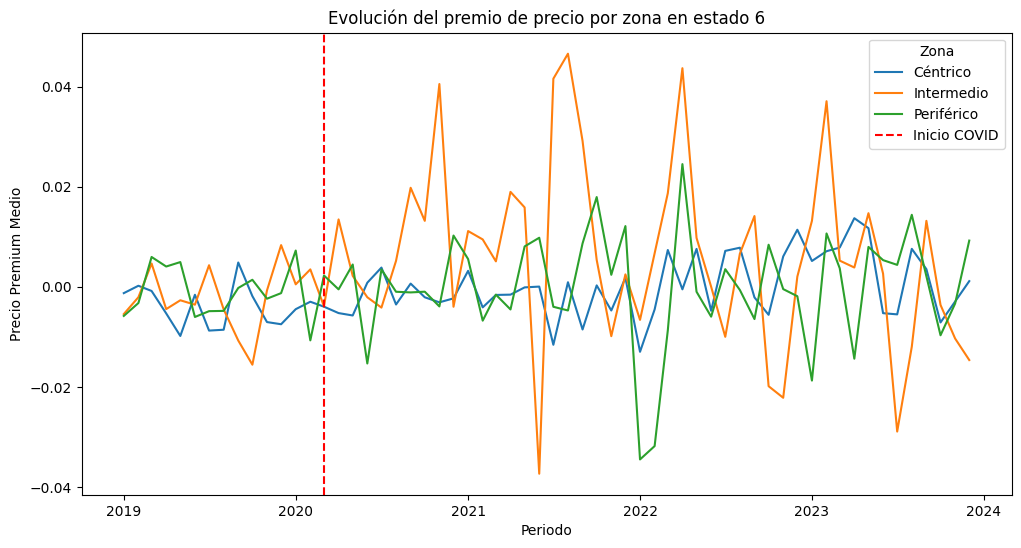

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

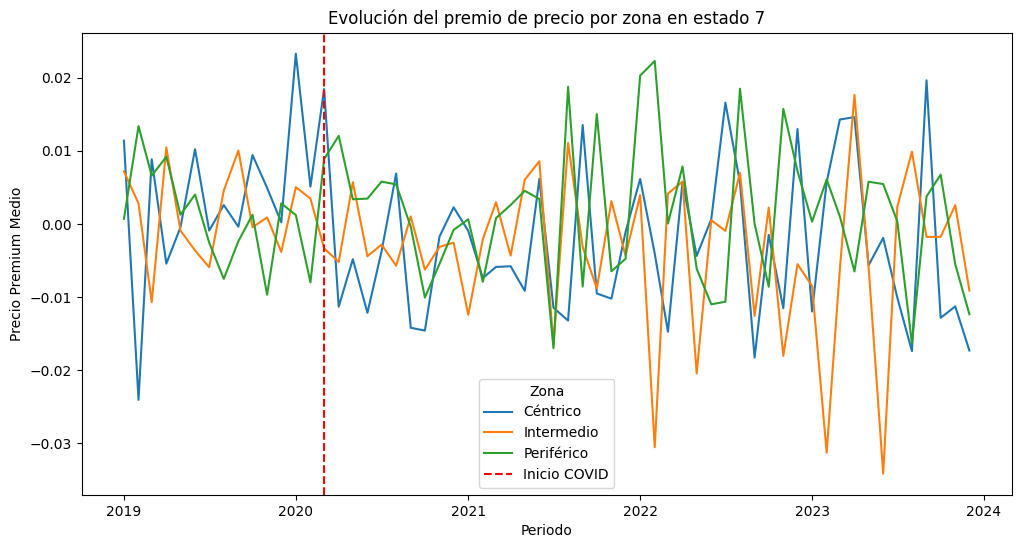

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

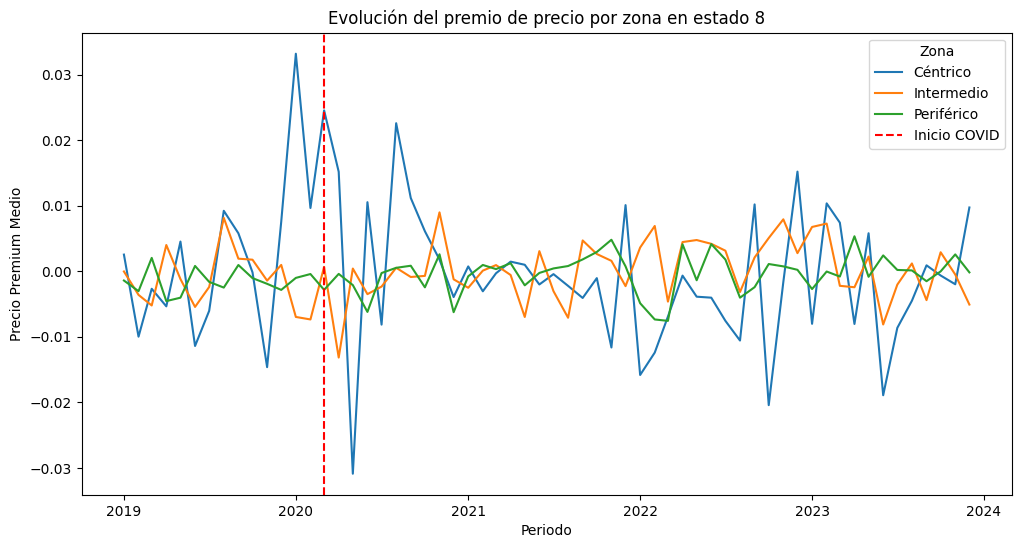

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

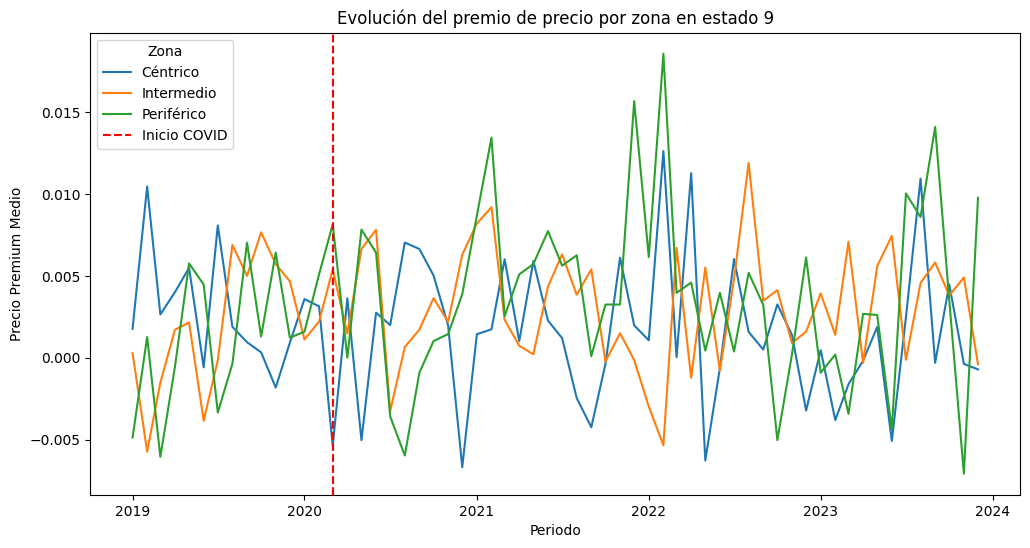

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

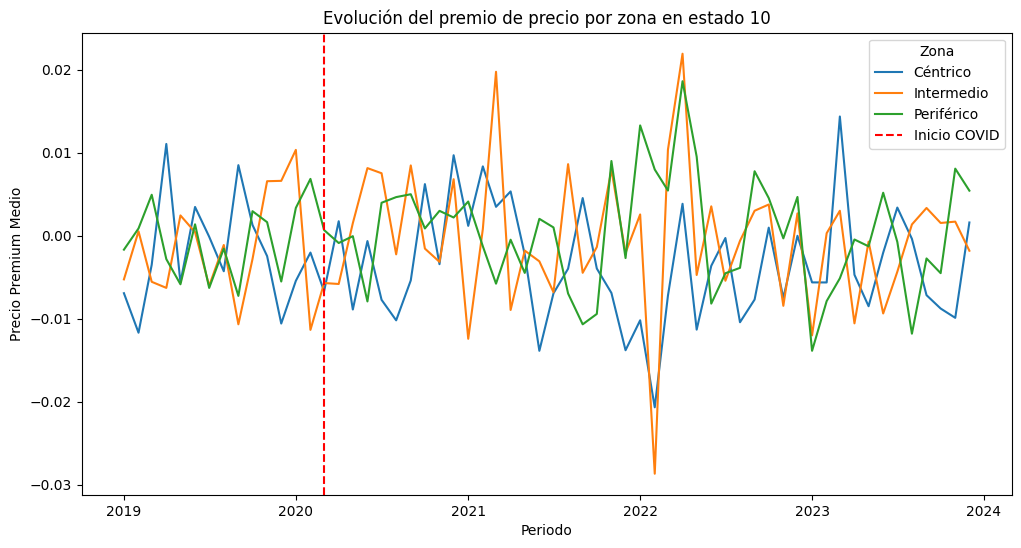

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

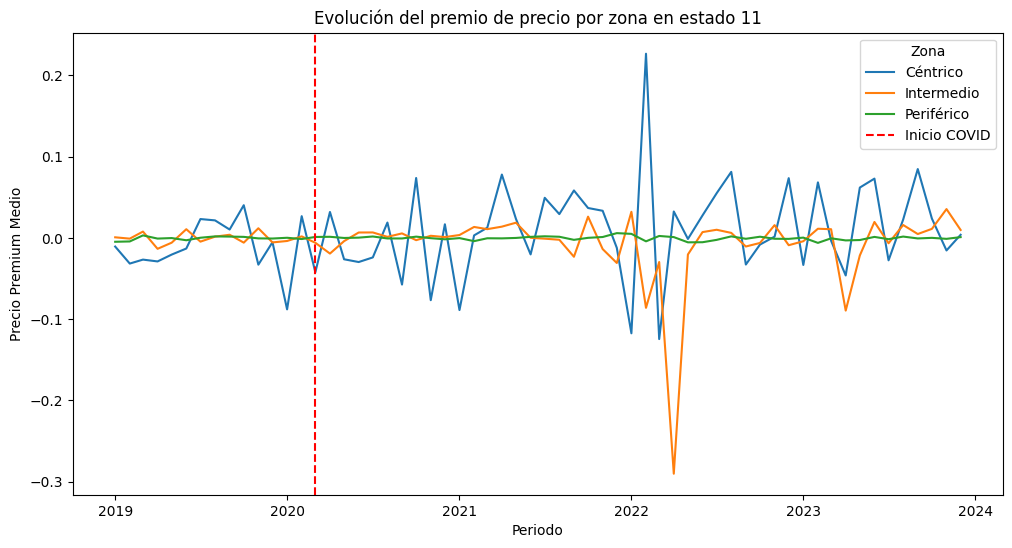

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

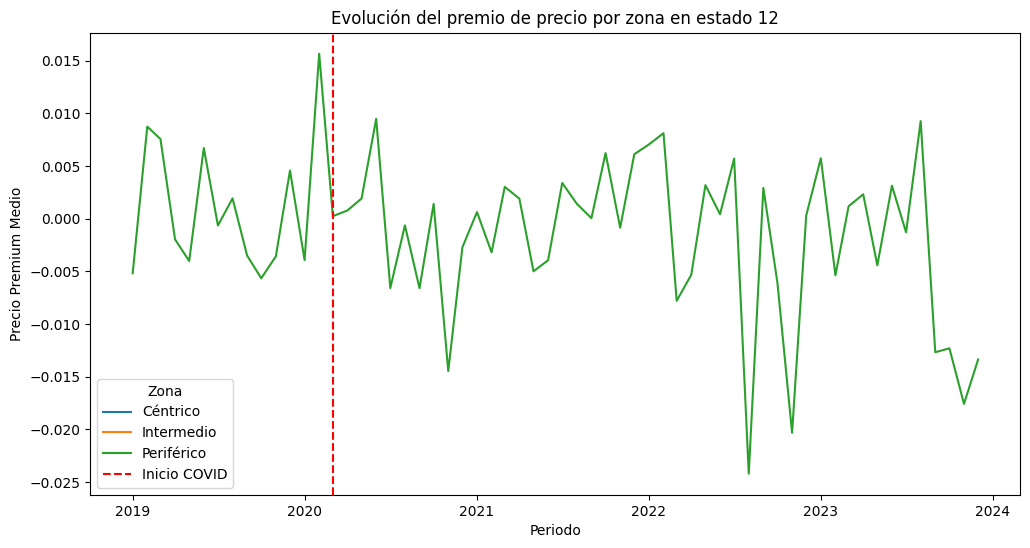

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

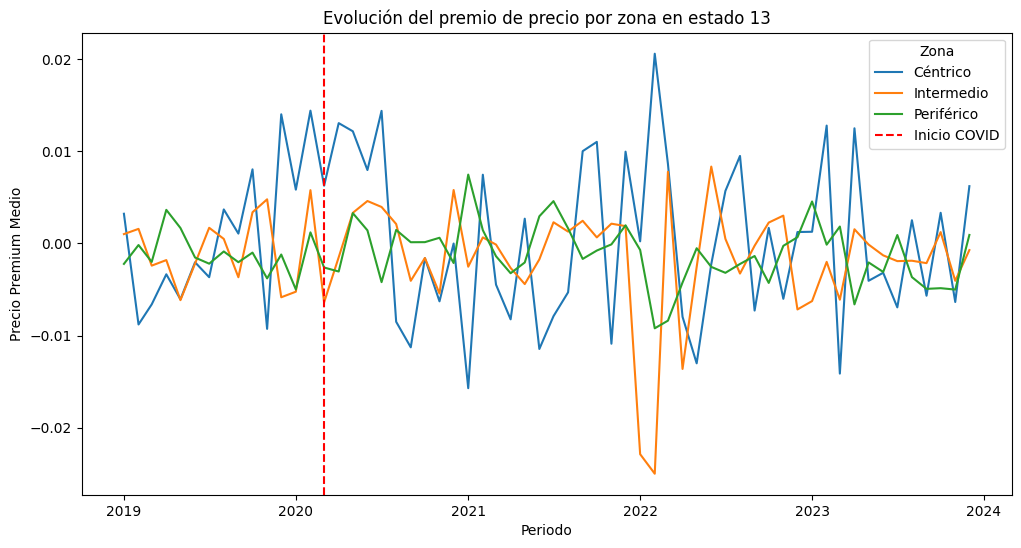

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

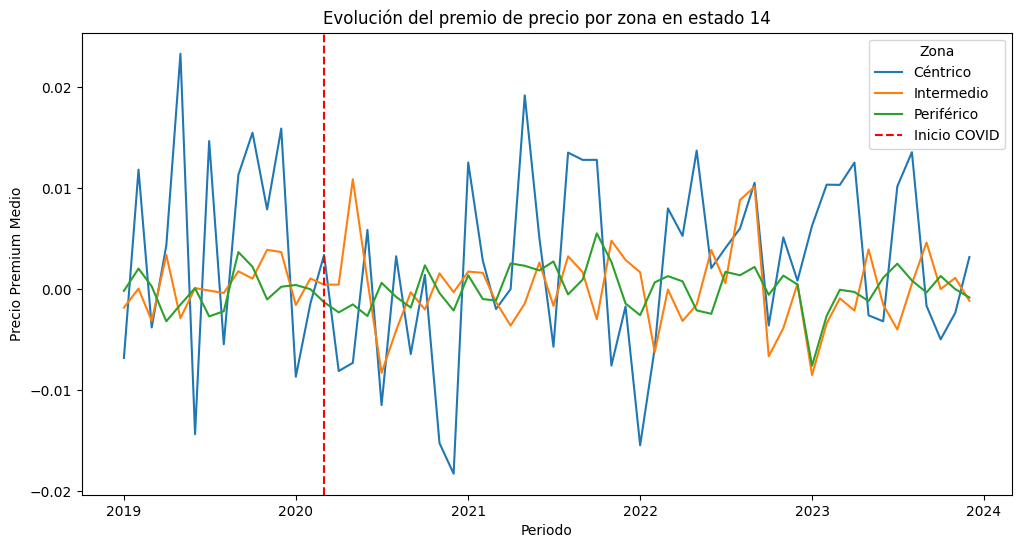

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

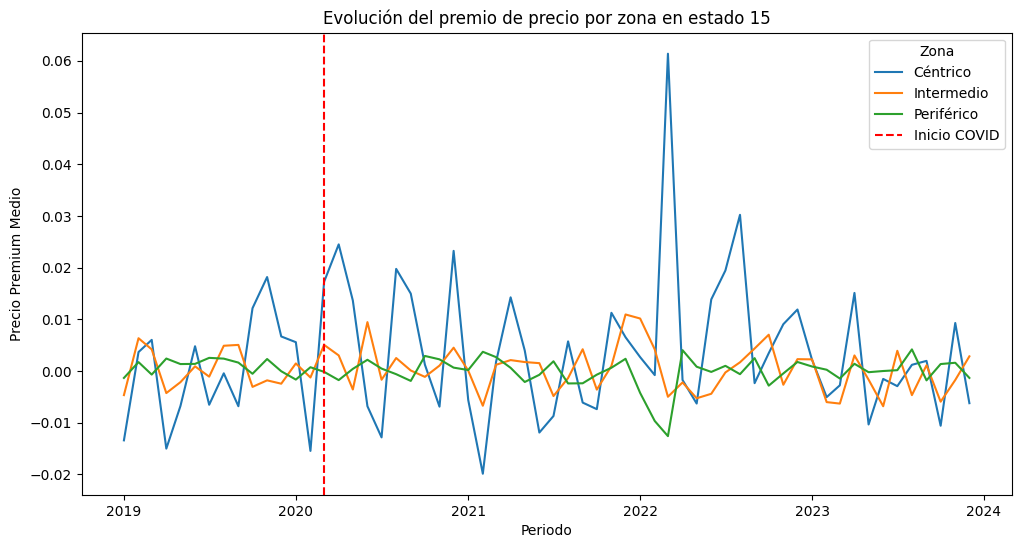

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

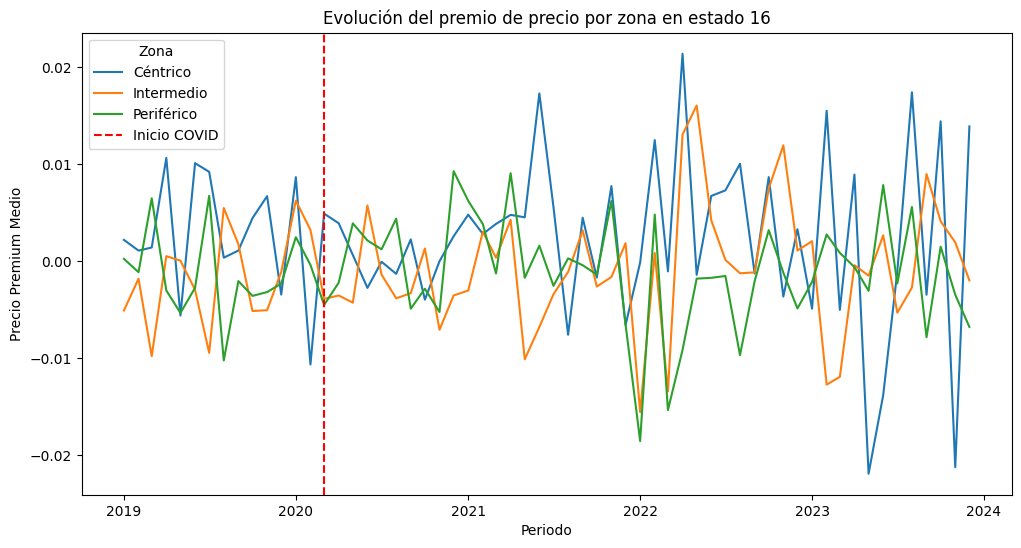

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

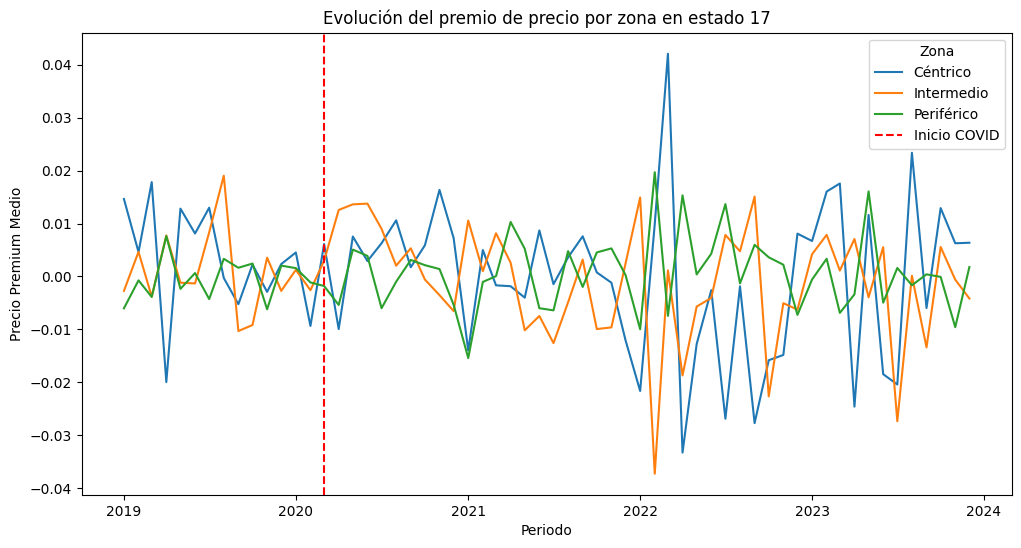

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

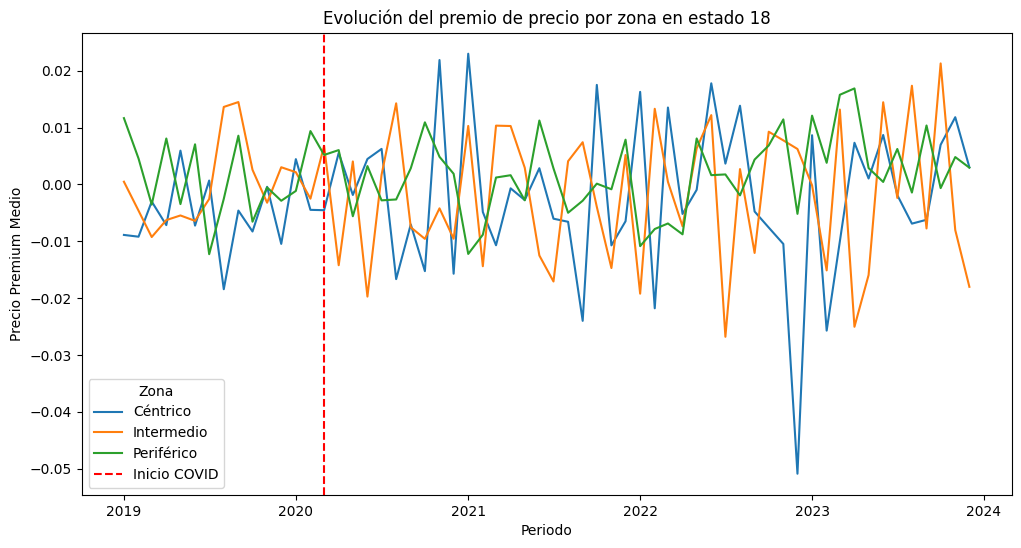

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

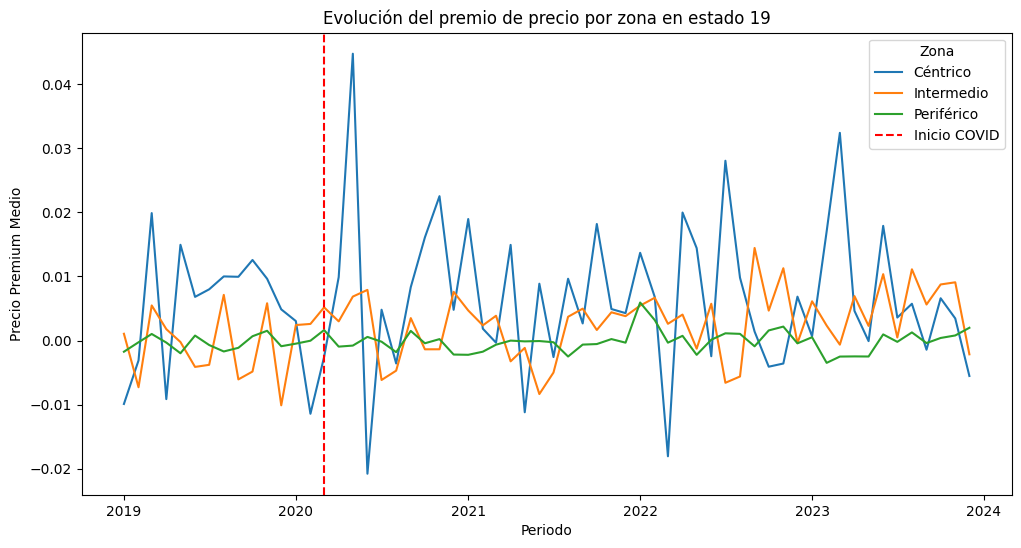

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

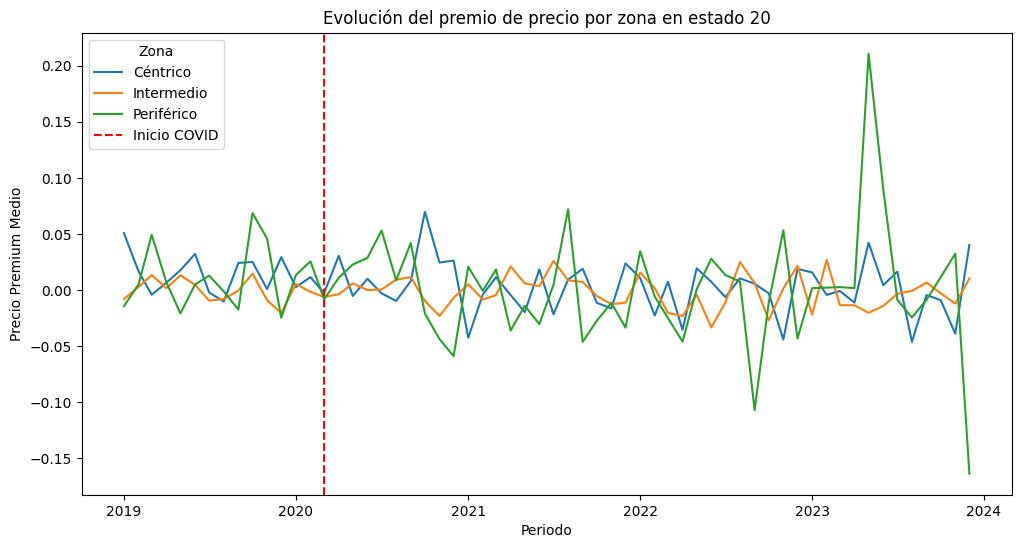

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

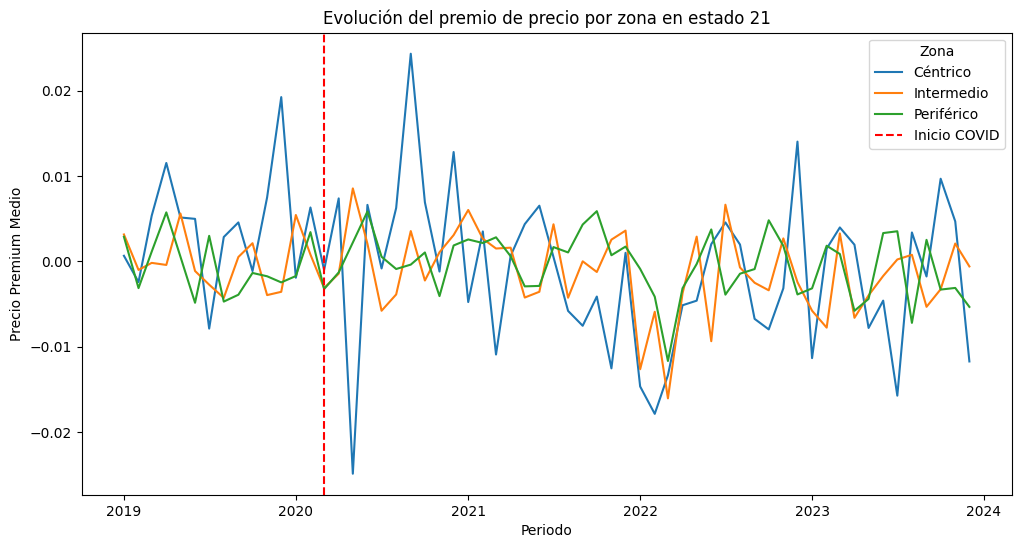

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

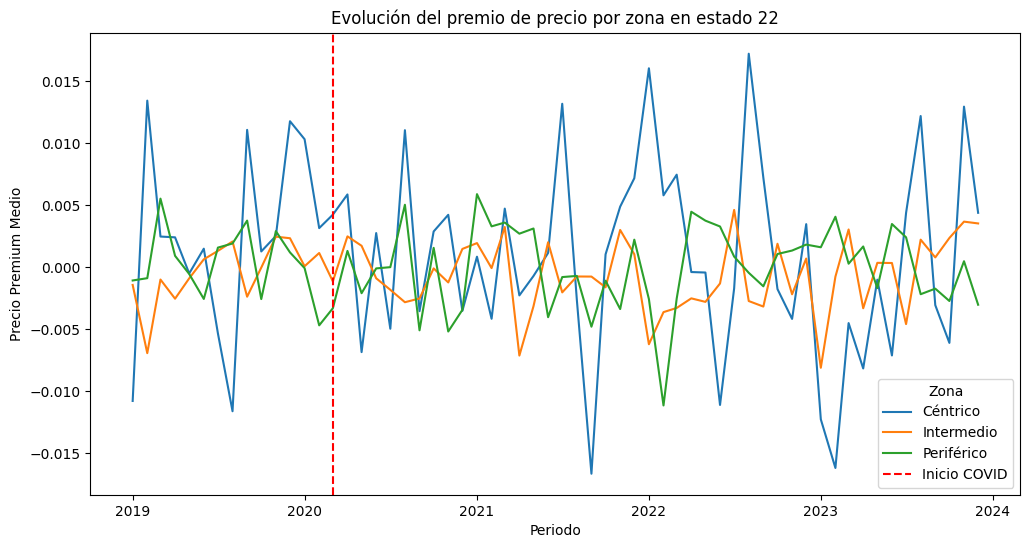

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

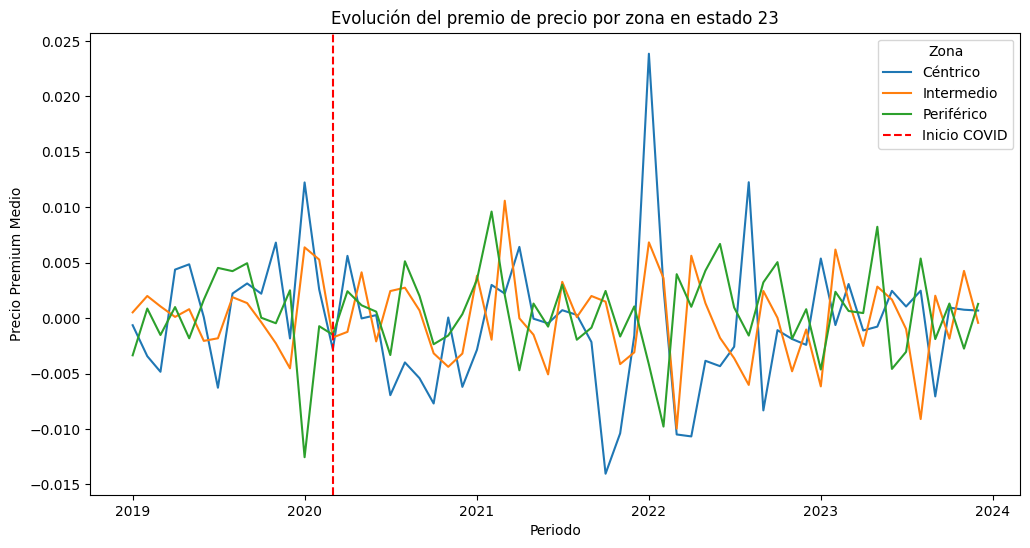

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

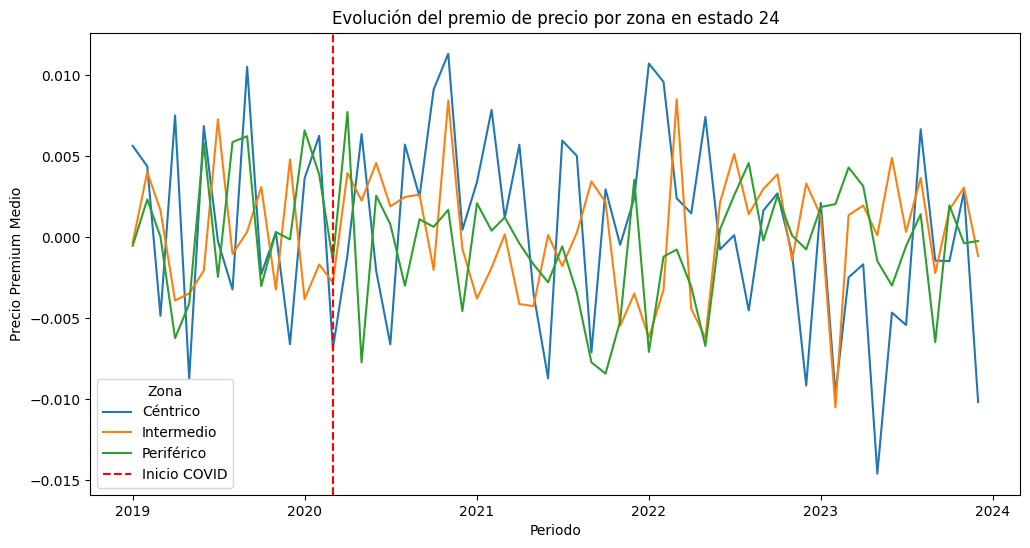

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

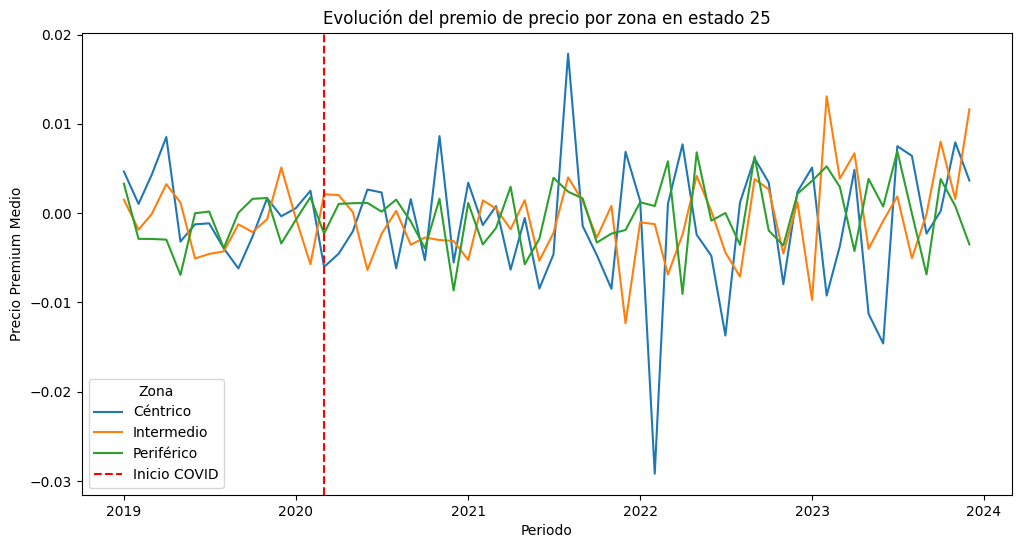

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

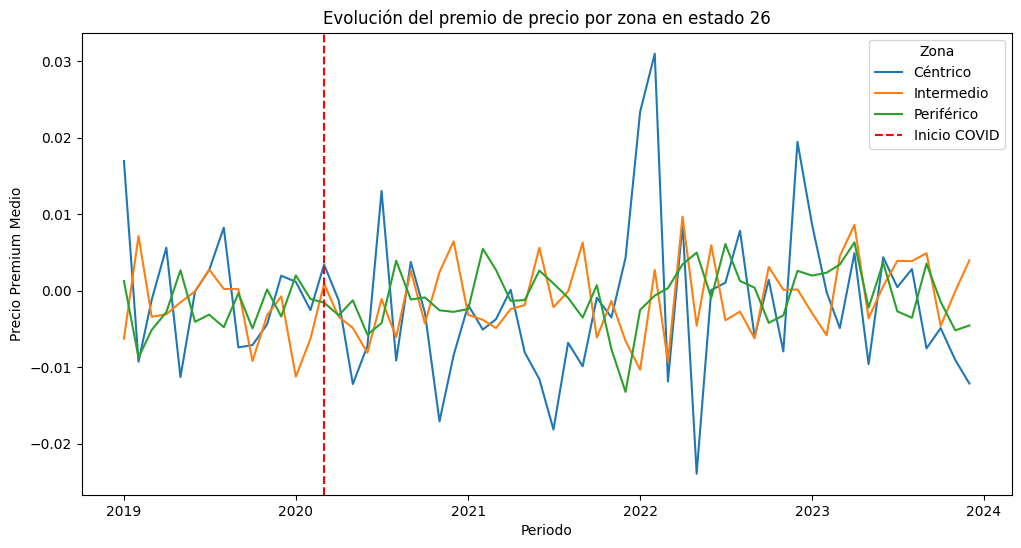

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

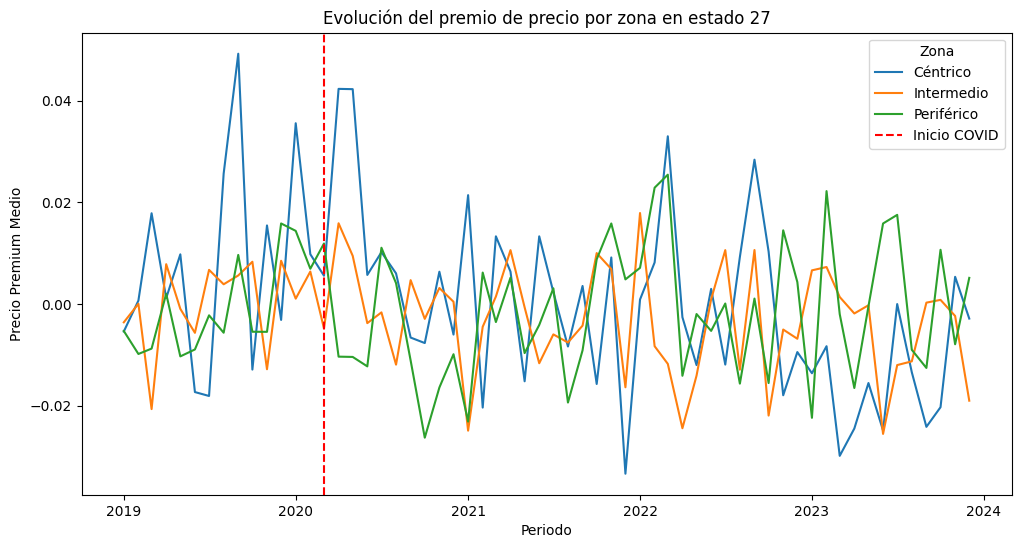

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

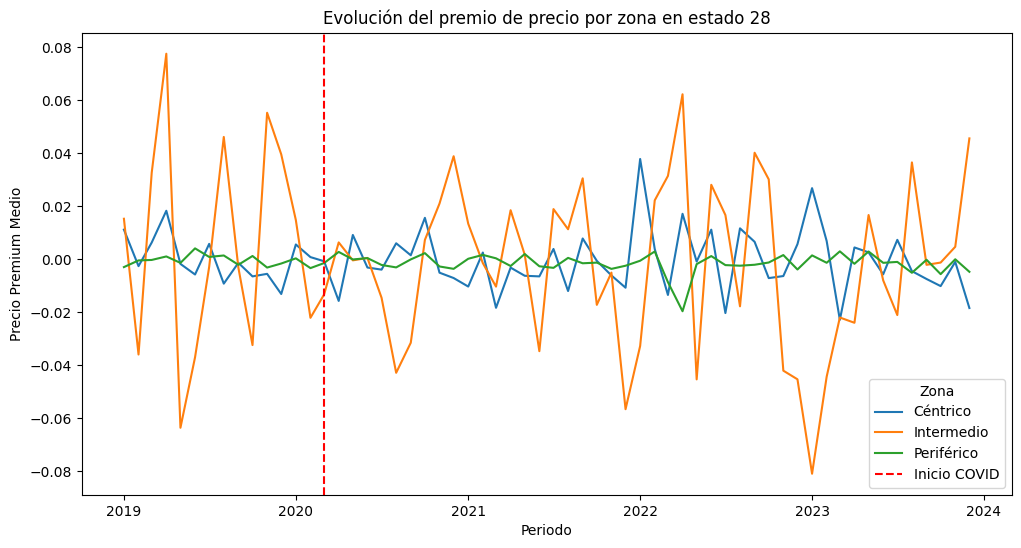

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

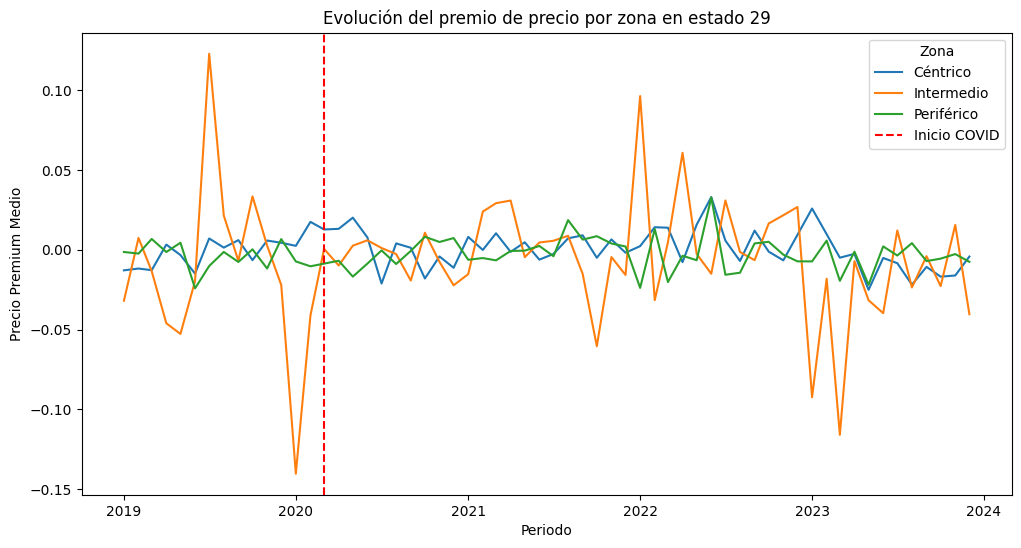

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

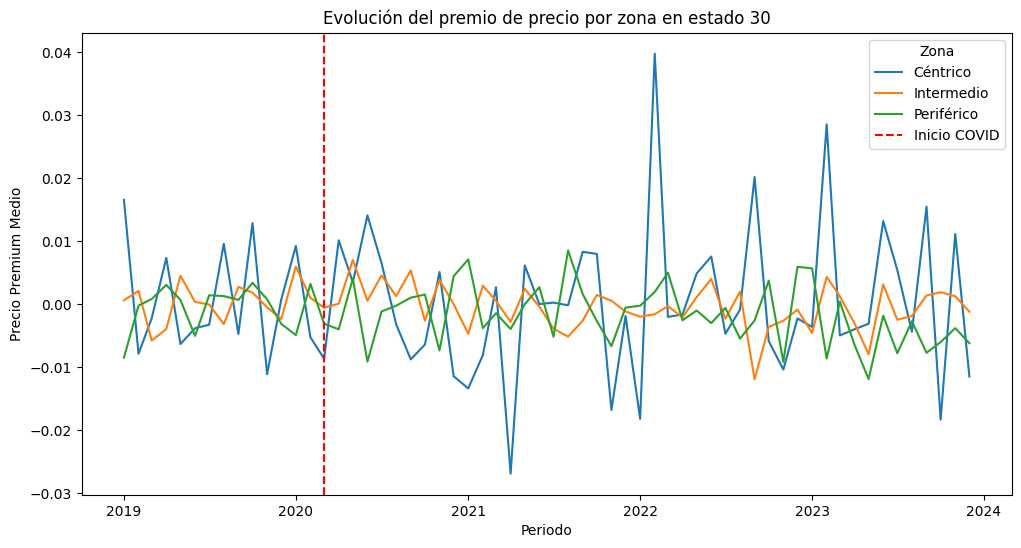

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

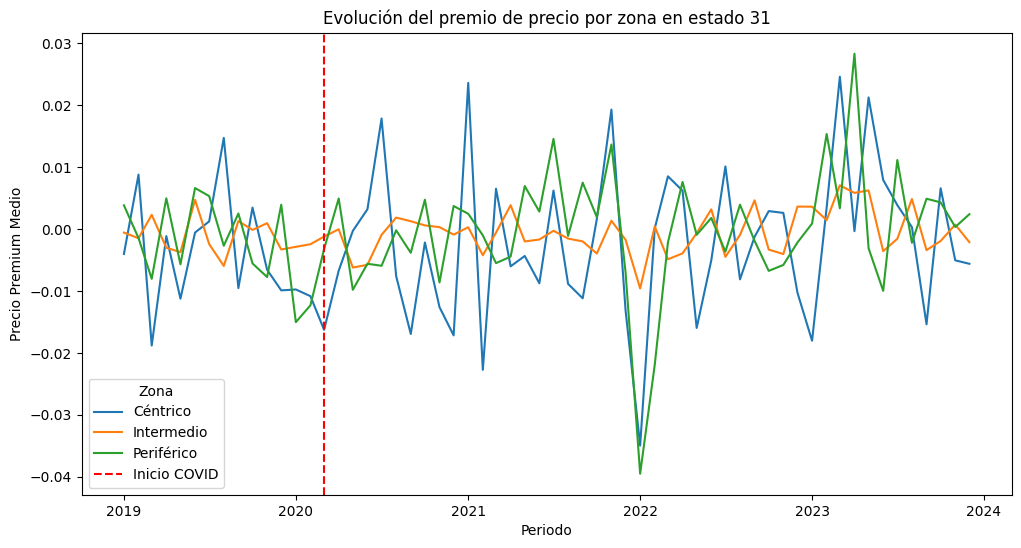

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

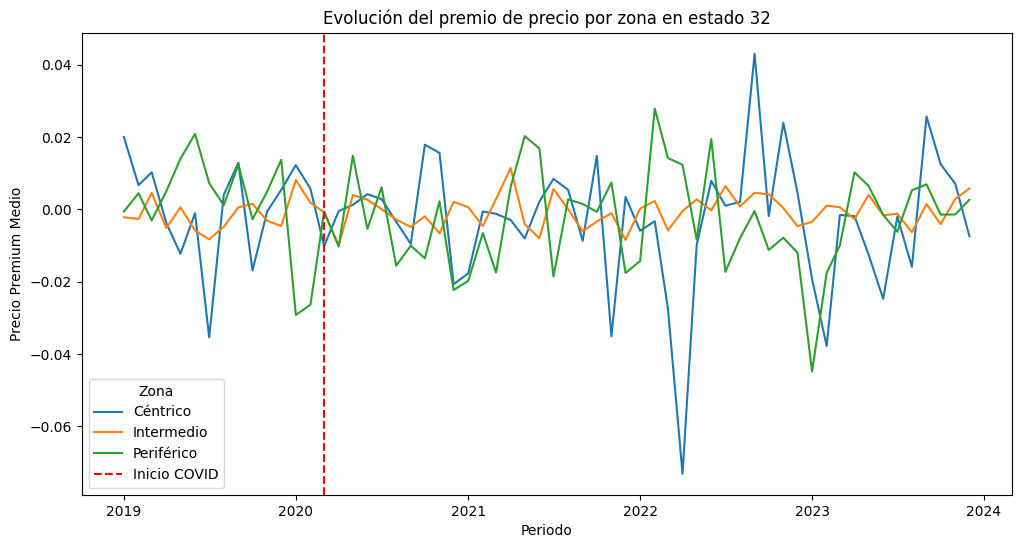

In [87]:
# Si 'period' es PeriodDtype:
series_zona_estado['period'] = series_zona_estado['period'].dt.to_timestamp()

# Ahora sí es datetime64[ns] y se puede plotear
import matplotlib.pyplot as plt
import seaborn as sns

for estado in series_zona_estado['state_id'].unique():
    sub = series_zona_estado[series_zona_estado['state_id'] == estado]
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(
        data=sub,
        x='period',
        y='price_premium_mean',
        hue='zona',
        ax=ax
    )
    ax.set_title(f'Evolución del premio de precio por zona en estado {estado}')
    ax.axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', label='Inicio COVID')
    ax.set_xlabel('Periodo')
    ax.set_ylabel('Precio Premium Medio')
    ax.legend(title='Zona')
    plt.show()

In [89]:
print(series_zona_estado.columns)

Index(['state_id', 'zona', 'period', 'price_premium_mean', 'volume'], dtype='object')


In [90]:
import statsmodels.formula.api as smf

for estado in series_zona_estado['state_id'].unique():
    data = series_zona_estado[series_zona_estado['state_id'] == estado].copy()
    data['post'] = (data['period'] >= pd.Timestamp('2020-03-01')).astype(int)
    data['tratamiento'] = (data['zona'] == 'Céntrico').astype(int)
    model = smf.ols('price_premium_mean ~ tratamiento * post', data=data).fit()
    print(f"Estado {estado}")
    print(model.summary())

Estado 1
                            OLS Regression Results                            
Dep. Variable:     price_premium_mean   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.5122
Date:                Sat, 05 Jul 2025   Prob (F-statistic):              0.674
Time:                        19:56:18   Log-Likelihood:                 640.31
No. Observations:                 180   AIC:                            -1273.
Df Residuals:                     176   BIC:                            -1260.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0020    

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1965: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [92]:
import statsmodels.formula.api as smf
import pandas as pd

resultados_did = []

for estado in series_zona_estado['state_id'].unique():
    data = series_zona_estado[series_zona_estado['state_id'] == estado].copy()
    data['post'] = (data['period'] >= pd.Timestamp('2020-03-01')).astype(int)
    data['tratamiento'] = (data['zona'] == 'Céntrico').astype(int)
    # Usa la columna correcta para el precio premium
    model = smf.ols('price_premium_mean ~ tratamiento * post', data=data).fit()
    coef = model.params.get('tratamiento:post', float('nan'))
    stderr = model.bse.get('tratamiento:post', float('nan'))
    pval = model.pvalues.get('tratamiento:post', float('nan'))
    resultados_did.append({
        'state_id': estado,
        'coef_tratamiento_post': coef,
        'stderr': stderr,
        'pval': pval
    })

df_did_summary = pd.DataFrame(resultados_did)
print(df_did_summary)

    state_id  coef_tratamiento_post    stderr      pval
0          1               0.000923  0.002609  0.723968
1          2               0.000000  0.000000       NaN
2          3              -0.003847  0.004511  0.394916
3          4               0.018237  0.015341  0.236215
4          5               0.000158  0.002021  0.937923
5          6              -0.000498  0.004375  0.909507
6          7              -0.003805  0.003706  0.306040
7          8              -0.003694  0.002628  0.161523
8          9              -0.003366  0.001643  0.042010
9         10              -0.002532  0.002625  0.336126
10        11               0.024765  0.015089  0.102537
11        12               0.000000  0.000000       NaN
12        13               0.000063  0.002345  0.978643
13        14              -0.002500  0.002216  0.260758
14        15               0.005361  0.003068  0.082295
15        16              -0.000811  0.002521  0.748096
16        17              -0.003076  0.003972  0

Puedes visualizar este resumen en un mapa de México para identificar dónde el efecto fue mayor o menor.

El coeficiente positivo/negativo indica el efecto causal promedio del COVID-19 en el premio de precio de la zona céntrica respecto a la periférica/intermedia, como en Zeng & Yi (2022).


In [98]:
import statsmodels.formula.api as smf
import pandas as pd

resultados_did = []

for estado in series_zona_estado['state_id'].unique():
    data = series_zona_estado[series_zona_estado['state_id'] == estado].copy()
    data['post'] = (data['period'] >= pd.Timestamp('2020-03-01')).astype(int)
    data['tratamiento'] = (data['zona'] == 'Céntrico').astype(int)
    model = smf.ols('price_premium_mean ~ tratamiento * post', data=data).fit()
    coef = model.params.get('tratamiento:post', float('nan'))
    stderr = model.bse.get('tratamiento:post', float('nan'))
    pval = model.pvalues.get('tratamiento:post', float('nan'))
    resultados_did.append({
        'state_id': estado,
        'coef_tratamiento_post': coef,
        'stderr': stderr,
        'pval': pval
    })

df_did_summary = pd.DataFrame(resultados_did)

In [99]:
# Extrae solo los estados con efectos significativos (p < 0.05)
significativos = df_did_summary[df_did_summary['pval'] < 0.05].copy()

# Ordena por magnitud del efecto
significativos = significativos.sort_values('coef_tratamiento_post', ascending=False)

print("Estados con efectos DID significativos (p < 0.05):")
print(significativos)

Estados con efectos DID significativos (p < 0.05):
    state_id  coef_tratamiento_post    stderr      pval
8          9              -0.003366  0.001643  0.042010
20        21              -0.004803  0.002239  0.033292


In [103]:
from INEGIpy import MarcoGeoestadistico
geo_framework = MarcoGeoestadistico()
# get all mexico states
gdf_mex_states = geo_framework.Entidades()
gdf_mex_states.head()

geometry cvegeo cve_agee  \
0  MULTIPOLYGON (((-102.29739 22.45527, -102.2955...     01       01   
1  MULTIPOLYGON (((-114.11561 28.09639, -114.1152...     02       02   
2  MULTIPOLYGON (((-109.89451 22.87476, -109.8946...     03       03   
3  MULTIPOLYGON (((-91.95650 20.19700, -91.95636 ...     04       04   
4  MULTIPOLYGON (((-102.31549 29.88000, -102.3150...     05       05   

               nom_agee nom_abrev      pob  pob_fem  pob_mas      viv  
0        Aguascalientes      Ags.  1425607   728924   696683   386671  
1       Baja California        BC  3769020  1868431  1900589  1149563  
2   Baja California Sur       BCS   798447   392568   405879   240660  
3              Campeche     Camp.   928363   471424   456939   260824  
4  Coahuila de Zaragoza     Coah.  3146771  1583102  1563669   901249

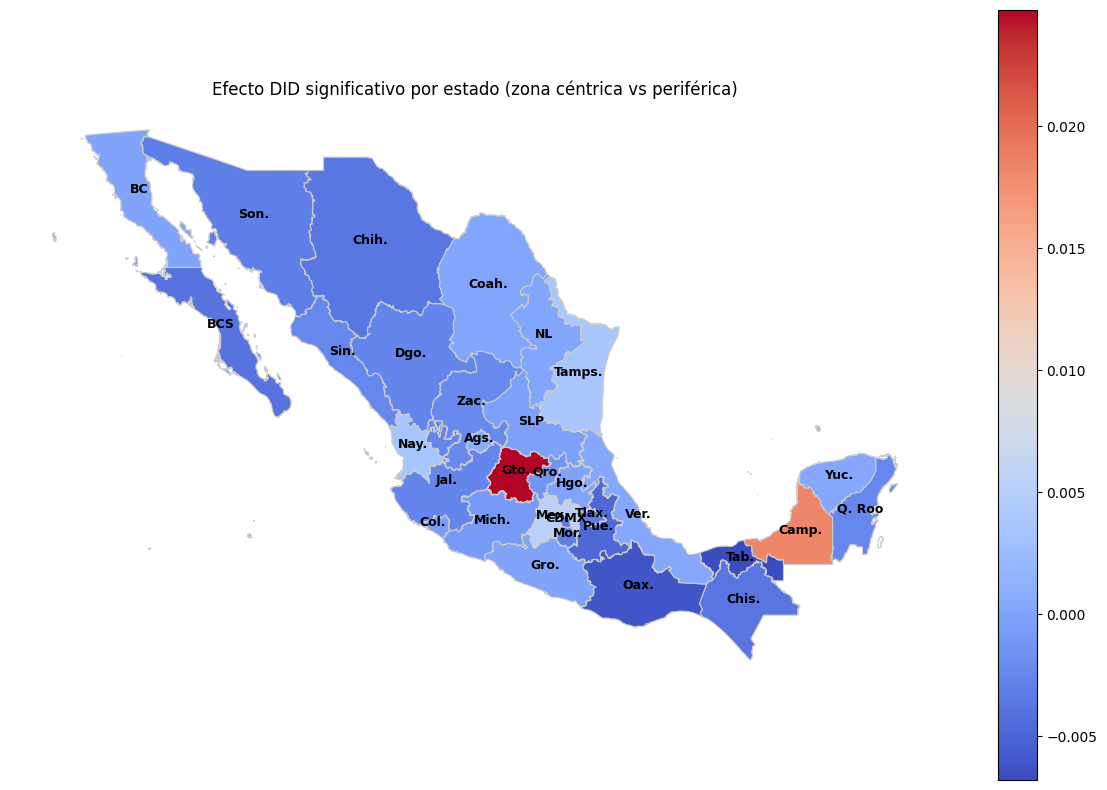

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# Solo plotea estados con efecto significativo
gdf_plot.dropna(subset=['coef_tratamiento_post']).plot(
    column='coef_tratamiento_post',
    cmap='coolwarm',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    missing_kwds={'color': 'lightgrey', 'label': 'Sin efecto significativo'}
)
# Agrega etiquetas con el nombre del estado
for idx, row in gdf_plot.dropna(subset=['coef_tratamiento_post']).iterrows():
    plt.annotate(
        text= row.get('nom_abrev', row.get('nom_agee', '')),   # usa text= en lugar de s=
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center',
        fontsize=9,
        color='black',
        weight='bold'
    )

plt.title('Efecto DID significativo por estado (zona céntrica vs periférica)')
plt.axis('off')
plt.show()

- Rojo: efecto positivo (premio de precio subió más en zonas céntricas).
- Azul: efecto negativo (premio de precio cayó más en zonas céntricas).
- Gris: sin datos o efecto no estimado.

In [109]:
def interpreta_efecto(row):
    if pd.isna(row['coef_tratamiento_post']):
        return "Sin datos suficientes para estimar efecto."
    elif row['pval'] >= 0.05:
        return "El efecto no es estadísticamente significativo."
    elif row['coef_tratamiento_post'] > 0:
        return f"Efecto positivo y significativo: tras COVID-19, el premio de precio en zonas céntricas subió {row['coef_tratamiento_post']*100:.2f}% más que en zonas periféricas/intermedias."
    else:
        return f"Efecto negativo y significativo: tras COVID-19, el premio de precio en zonas céntricas cayó {abs(row['coef_tratamiento_post']*100):.2f}% más que en zonas periféricas/intermedias."

df_did_summary['interpretacion'] = df_did_summary.apply(interpreta_efecto, axis=1)
print(df_did_summary[['state_id', 'coef_tratamiento_post', 'pval', 'interpretacion']])
df_did_summary.to_excel('resumen_DID_por_estado.xlsx', index=False)

    state_id  coef_tratamiento_post      pval  \
0          1               0.000923  0.723968   
1          2               0.000000       NaN   
2          3              -0.003847  0.394916   
3          4               0.018237  0.236215   
4          5               0.000158  0.937923   
5          6              -0.000498  0.909507   
6          7              -0.003805  0.306040   
7          8              -0.003694  0.161523   
8          9              -0.003366  0.042010   
9         10              -0.002532  0.336126   
10        11               0.024765  0.102537   
11        12               0.000000       NaN   
12        13               0.000063  0.978643   
13        14              -0.002500  0.260758   
14        15               0.005361  0.082295   
15        16              -0.000811  0.748096   
16        17              -0.003076  0.439758   
17        18               0.003523  0.372645   
18        19               0.000115  0.966930   
19        20        

## Modelo VAR para todos los estados de la República Mexicana, siguiendo la metodología de Zeng & Yi (2022)

Analizar la correlación contemporánea entre zonas (Céntrico, Intermedio, Periférico) en cada estado, incluso cuando el VAR es de orden 0. Esto es relevante porque, como muestra la literatura (Zeng & Yi, 2022), la correlación contemporánea puede indicar relaciones estructurales entre submercados aunque no haya dinámica temporal significativa.


In [120]:
from statsmodels.tsa.api import VAR

# Catálogo de nombres de estados (ajusta si usas otro)
catalogo_estados = {
    1: 'Aguascalientes', 2: 'Baja California', 3: 'Baja California Sur', 4: 'Campeche',
    5: 'Coahuila', 6: 'Colima', 7: 'Chiapas', 8: 'Chihuahua', 9: 'CDMX', 10: 'Durango',
    11: 'Guanajuato', 12: 'Guerrero', 13: 'Hidalgo', 14: 'Jalisco', 15: 'México',
    16: 'Michoacán', 17: 'Morelos', 18: 'Nayarit', 19: 'Nuevo León', 20: 'Oaxaca',
    21: 'Puebla', 22: 'Querétaro', 23: 'Quintana Roo', 24: 'San Luis Potosí',
    25: 'Sinaloa', 26: 'Sonora', 27: 'Tabasco', 28: 'Tamaulipas', 29: 'Tlaxcala',
    30: 'Veracruz', 31: 'Yucatán', 32: 'Zacatecas'
}

resultados_var = []
correlaciones = []

for estado in series_zona_estado['state_id'].unique():
    nombre_estado = catalogo_estados.get(estado, f"Estado {estado}")
    df_estado = series_zona_estado[series_zona_estado['state_id'] == estado]
    df_var = df_estado.pivot(index='period', columns='zona', values='price_premium_mean').dropna()
    # Asigna frecuencia mensual explícita al índice
    df_var.index = pd.DatetimeIndex(df_var.index)
    df_var = df_var.asfreq('MS')  # 'MS' = Month Start
    # Solo ajusta VAR si hay al menos 2 zonas y suficiente longitud temporal
    if df_var.shape[1] >= 2 and df_var.shape[0] > 12:
        try:
            model = VAR(df_var)
            results = model.fit(maxlags=2, ic='aic')
            # Correlación contemporánea de los residuos
            corr = results.resid.corr()
            correlaciones.append({
                'state_id': estado,
                'nombre_estado': nombre_estado,
                'correlacion': corr
            })
            resultados_var.append({
                'state_id': estado,
                'nombre_estado': nombre_estado,
                'k_ar': results.k_ar,
                'AIC': results.aic
            })
            print(f"{nombre_estado} (Estado {estado}): VAR({results.k_ar}) ajustado. AIC={results.aic:.3f}")
            print("Correlación contemporánea entre zonas:")
            print(corr)
            print("-" * 40)
        except Exception as e:
            print(f"{nombre_estado} (Estado {estado}): Error al ajustar VAR - {e}")
    else:
        print(f"{nombre_estado} (Estado {estado}): No hay suficientes datos para VAR.")

# Resumen tabular de resultados VAR
df_var_resumen = pd.DataFrame(resultados_var)
print("\nResumen VAR por estado:")
print(df_var_resumen)

# Si quieres ver todas las correlaciones en un solo DataFrame:
corrs_df = pd.DataFrame([
    {'state_id': c['state_id'], 'nombre_estado': c['nombre_estado'], 'correlacion': c['correlacion'].to_dict()}
    for c in correlaciones
])
print("\nCorrelaciones contemporáneas por estado:")
print(corrs_df)

Aguascalientes (Estado 1): VAR(0) ajustado. AIC=-30.769
Correlación contemporánea entre zonas:
            Céntrico  Intermedio  Periférico
Céntrico    1.000000    0.004942    0.016589
Intermedio  0.004942    1.000000    0.144917
Periférico  0.016589    0.144917    1.000000
----------------------------------------
Baja California (Estado 2): No hay suficientes datos para VAR.
Baja California Sur (Estado 3): VAR(0) ajustado. AIC=-26.801
Correlación contemporánea entre zonas:
            Céntrico  Intermedio  Periférico
Céntrico    1.000000    0.265707   -0.064017
Intermedio  0.265707    1.000000   -0.138732
Periférico -0.064017   -0.138732    1.000000
----------------------------------------
Campeche (Estado 4): Error al ajustar VAR - array must not contain infs or NaNs
Coahuila (Estado 5): VAR(0) ajustado. AIC=-32.060
Correlación contemporánea entre zonas:
            Céntrico  Intermedio  Periférico
Céntrico    1.000000    0.051263    0.247897
Intermedio  0.051263    1.000000    0.268

### ¿Cómo interpretar y reportar?
La matriz de correlación contemporánea muestra la relación entre los shocks de las zonas en cada estado en el mismo periodo (por ejemplo, si un shock en zona céntrica se asocia con un shock en zona periférica).

El orden del VAR (k_ar) indica si hay dinámica temporal relevante. Si es 0, la correlación contemporánea es lo más relevante.

El AIC permite comparar la calidad del ajuste entre estados.


**Respaldo metodológico**


Así lo hacen Zeng & Yi (2022): reportan correlaciones contemporáneas y dinámicas entre submercados para entender la transmisión de shocks y la segmentación del mercado inmobiliario.

La correlación contemporánea es esencial cuando el VAR es de orden 0, ya que no hay rezagos temporales.

In [122]:
for c in correlaciones:
    plt.figure(figsize=(6,5))
    sns.heatmap(c['correlacion'], annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
    plt.title(f'Correlación contemporánea entre zonas\n{c["nombre_estado"]}')
    plt.tight_layout()
    plt.savefig(f'correlacion_zonas_{c["nombre_estado"].replace(" ", "_")}.png')
    plt.close()

In [123]:
with pd.ExcelWriter('correlaciones_zonas_por_estado.xlsx') as writer:
    for c in correlaciones:
        df_corr = c['correlacion']
        # Si es DataFrame, úsalo directo; si es dict, conviértelo
        if isinstance(df_corr, dict):
            df_corr = pd.DataFrame(df_corr)
        df_corr.to_excel(writer, sheet_name=c['nombre_estado'][:31])  # Excel limita el nombre de hoja a 31 caracteres

In [124]:
rows = []
for c in correlaciones:
    flat_corr = c['correlacion'].unstack() if hasattr(c['correlacion'], 'unstack') else pd.Series(c['correlacion'])
    flat_corr = flat_corr.rename(lambda x: f"{x[0]}-{x[1]}" if isinstance(x, tuple) else x)
    row = {'state_id': c['state_id'], 'nombre_estado': c['nombre_estado']}
    row.update(flat_corr.to_dict())
    rows.append(row)
df_corr_flat = pd.DataFrame(rows)
df_corr_flat.to_excel('correlacion_zonas_resumen.xlsx', index=False)

#### Interpretación 

In [125]:
def interpreta_correlacion(corr_matrix):
    interpretaciones = []
    for zona1 in corr_matrix.columns:
        for zona2 in corr_matrix.columns:
            if zona1 != zona2:
                coef = corr_matrix.loc[zona1, zona2]
                if abs(coef) > 0.5:
                    fuerza = "fuerte"
                elif abs(coef) > 0.3:
                    fuerza = "moderada"
                elif abs(coef) > 0.1:
                    fuerza = "débil"
                else:
                    fuerza = "muy baja"
                if coef > 0:
                    signo = "positiva"
                elif coef < 0:
                    signo = "negativa"
                else:
                    signo = "nula"
                interpretaciones.append(
                    f"Correlación {fuerza} y {signo} entre '{zona1}' y '{zona2}' (coef: {coef:.2f})"
                )
    return interpretaciones

# Ejemplo para un estado
for c in correlaciones:
    print(f"--- {c['nombre_estado']} ---")
    for interp in interpreta_correlacion(c['correlacion']):
        print(interp)
    print()

--- Aguascalientes ---
Correlación muy baja y positiva entre 'Céntrico' y 'Intermedio' (coef: 0.00)
Correlación muy baja y positiva entre 'Céntrico' y 'Periférico' (coef: 0.02)
Correlación muy baja y positiva entre 'Intermedio' y 'Céntrico' (coef: 0.00)
Correlación débil y positiva entre 'Intermedio' y 'Periférico' (coef: 0.14)
Correlación muy baja y positiva entre 'Periférico' y 'Céntrico' (coef: 0.02)
Correlación débil y positiva entre 'Periférico' y 'Intermedio' (coef: 0.14)

--- Baja California Sur ---
Correlación débil y positiva entre 'Céntrico' y 'Intermedio' (coef: 0.27)
Correlación muy baja y negativa entre 'Céntrico' y 'Periférico' (coef: -0.06)
Correlación débil y positiva entre 'Intermedio' y 'Céntrico' (coef: 0.27)
Correlación débil y negativa entre 'Intermedio' y 'Periférico' (coef: -0.14)
Correlación muy baja y negativa entre 'Periférico' y 'Céntrico' (coef: -0.06)
Correlación débil y negativa entre 'Periférico' y 'Intermedio' (coef: -0.14)

--- Coahuila ---
Correlación 

**¿Cómo interpretar?**

Fuerte positiva: Las fluctuaciones de precios en ambas zonas tienden a moverse juntas (ej. shock en céntrico se transmite a periférico).

Fuerte negativa: Cuando una zona sube, la otra tiende a bajar, lo que sugiere mercados parcialmente sustitutos o efectos de desplazamiento.

Débil o nula: Los submercados están segmentados y responden de forma independiente.

Literatura:
Zeng & Yi (2022) encuentran que la correlación contemporánea alta indica transmisión rápida de shocks, mientras que correlaciones bajas sugieren segmentación de submercados. Tomal & Helbich (2022) muestran que la pandemia incrementó la heterogeneidad y la segmentación espacial.

In [126]:
rows = []
for c in correlaciones:
    corr = c['correlacion']
    row = {
        'state_id': c['state_id'],
        'nombre_estado': c['nombre_estado'],
        'Céntrico-Intermedio': corr.loc['Céntrico', 'Intermedio'] if 'Céntrico' in corr and 'Intermedio' in corr else None,
        'Céntrico-Periférico': corr.loc['Céntrico', 'Periférico'] if 'Céntrico' in corr and 'Periférico' in corr else None,
        'Intermedio-Periférico': corr.loc['Intermedio', 'Periférico'] if 'Intermedio' in corr and 'Periférico' in corr else None
    }
    rows.append(row)

df_corr_resumen = pd.DataFrame(rows)
df_corr_resumen.to_excel('correlacion_zonas_resumen.xlsx', index=False)
print(df_corr_resumen)


    state_id        nombre_estado  Céntrico-Intermedio  Céntrico-Periférico  \
0          1       Aguascalientes             0.004942             0.016589   
1          3  Baja California Sur             0.265707            -0.064017   
2          5             Coahuila             0.051263             0.247897   
3          7              Chiapas             0.097358             0.019163   
4          8            Chihuahua            -0.133108            -0.017068   
5          9                 CDMX            -0.419689             0.057641   
6         10              Durango             0.139862            -0.200019   
7         11           Guanajuato            -0.029629            -0.250688   
8         13              Hidalgo            -0.003168            -0.340400   
9         14              Jalisco             0.030899             0.174968   
10        15               México             0.183843            -0.475720   
11        16            Michoacán            -0.0262

## Causal Impact 

In [133]:
from causalimpact import CausalImpact

# Periodo Covid
pre_period_end = '2020-02-29'

def run_causal_impact(estado, zona_tratada='Céntrico', zona_control='Periférico'):
    nombre_estado = catalogo_estados.get(estado, f"Estado {estado}")
    df_estado = series_zona_estado[series_zona_estado['state_id'] == estado]
    df_wide = df_estado.pivot(index='period', columns='zona', values='price_premium_mean').dropna()
    # Asigna frecuencia mensual explícita al índice
    df_wide.index = pd.DatetimeIndex(df_wide.index)
    df_wide = df_wide.asfreq('MS')
    # Solo si ambas zonas existen
    if zona_tratada in df_wide.columns and zona_control in df_wide.columns:
        df_ci = df_wide[[zona_tratada, zona_control]]
        pre_period = [0, (df_ci.index <= pre_period_end).sum() - 1]
        post_period = [pre_period[1] + 1, len(df_ci) - 1]
        try:
            ci = CausalImpact(df_ci, pre_period, post_period)
            return ci, df_ci, nombre_estado, pre_period, post_period
        except Exception as e:
            print(f"{nombre_estado}: Error en CausalImpact - {e}")
            return None, None, nombre_estado, pre_period, post_period
    else:
        print(f"{nombre_estado}: No hay datos suficientes para CausalImpact.")
        return None, None, nombre_estado, None, None

resultados_ci = {}
for estado in series_zona_estado['state_id'].unique():
    ci, df_ci, nombre_estado, pre_period, post_period = run_causal_impact(estado)
    if ci is not None:
        resultados_ci[estado] = {
            'ci': ci,
            'df_ci': df_ci,
            'nombre_estado': nombre_estado,
            'pre_period': pre_period,
            'post_period': post_period
        }
        print(f"{nombre_estado}: análisis CausalImpact realizado.")

Aguascalientes: análisis CausalImpact realizado.
Baja California: No hay datos suficientes para CausalImpact.
Baja California Sur: análisis CausalImpact realizado.
Campeche: análisis CausalImpact realizado.
Coahuila: análisis CausalImpact realizado.
Colima: análisis CausalImpact realizado.
Chiapas: análisis CausalImpact realizado.
Chihuahua: análisis CausalImpact realizado.
CDMX: análisis CausalImpact realizado.
Durango: análisis CausalImpact realizado.
Guanajuato: análisis CausalImpact realizado.
Guerrero: No hay datos suficientes para CausalImpact.
Hidalgo: análisis CausalImpact realizado.
Jalisco: análisis CausalImpact realizado.
México: análisis CausalImpact realizado.
Michoacán: análisis CausalImpact realizado.
Morelos: análisis CausalImpact realizado.
Nayarit: análisis CausalImpact realizado.
Nuevo León: análisis CausalImpact realizado.
Oaxaca: análisis CausalImpact realizado.
Puebla: análisis CausalImpact realizado.
Querétaro: análisis CausalImpact realizado.
Quintana Roo: análi

### Visualización para un estado

In [140]:
print(df_ci.shape)         # ¿cuántas filas y columnas?
print(df_ci.columns)       # ¿qué columnas tienes?
print(df_ci.isna().sum())  # ¿tienes NaNs?

(60, 2)
CategoricalIndex(['Céntrico', 'Periférico'], categories=['Céntrico', 'Intermedio', 'Periférico'], ordered=True, dtype='category', name='zona')
zona
Céntrico      0
Periférico    0
dtype: int64


In [143]:
from causalimpact import CausalImpact
import matplotlib.pyplot as plt

# 1) Partimos de df_ci con índice 0…59 y columnas Céntrico, Periférico
print("Columnas originales:", df_ci.columns)
# → CategoricalIndex(['Céntrico','Periférico'],…)

# 2) Creamos un DataFrame solo con esas dos series
df_ci_causal = df_ci[['Céntrico', 'Periférico']].copy()

# 3) Renombramos columnas para evitar tildes
df_ci_causal.columns = ['y', 'x1']

# 4) Quitamos filas con NaN (si las hubiera) en pre/post
df_ci_causal = df_ci_causal.dropna()

# 5) Tus rangos pre/post ya calculados
pre_period  = [0, 13]
post_period = [14, len(df_ci_causal)-1]  # 59

# 6) Instancia CausalImpact sobre la matriz limpia
ci_test = CausalImpact(df_ci_causal, pre_period, post_period)

# 7) Comprueba que ahora haya inferencias
print("Inferences existen?", ci_test.inferences is not None)

if ci_test.inferences is not None:
    print(ci_test.summary())
    fig = ci_test.plot()
    plt.suptitle(f'CausalImpact: {nombre_estado}', fontsize=16)
    plt.show()
else:
    print("Sigue siendo None: revisa que df_ci_causal tenga suficientes filas (0–59) sin NaN.")

Columnas originales: CategoricalIndex(['Céntrico', 'Periférico'], categories=['Céntrico', 'Intermedio', 'Periférico'], ordered=True, dtype='category', name='zona')
Inferences existen? False
Sigue siendo None: revisa que df_ci_causal tenga suficientes filas (0–59) sin NaN.


                        Unobserved Components Results                         
Dep. Variable:               Céntrico   No. Observations:                   60
Model:                    local level   Log Likelihood                 213.821
Date:                Sun, 06 Jul 2025   AIC                           -421.642
Time:                        13:58:29   BIC                           -415.410
Sample:                    01-01-2019   HQIC                          -419.209
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   3.88e-05   6.09e-06      6.367      0.000    2.69e-05    5.07e-05
sigma2.level      2.508e-11   2.72e-07   9.23e-05      1.000   -5.33e-07    5.33e-07
beta.Periférico      0.0108 

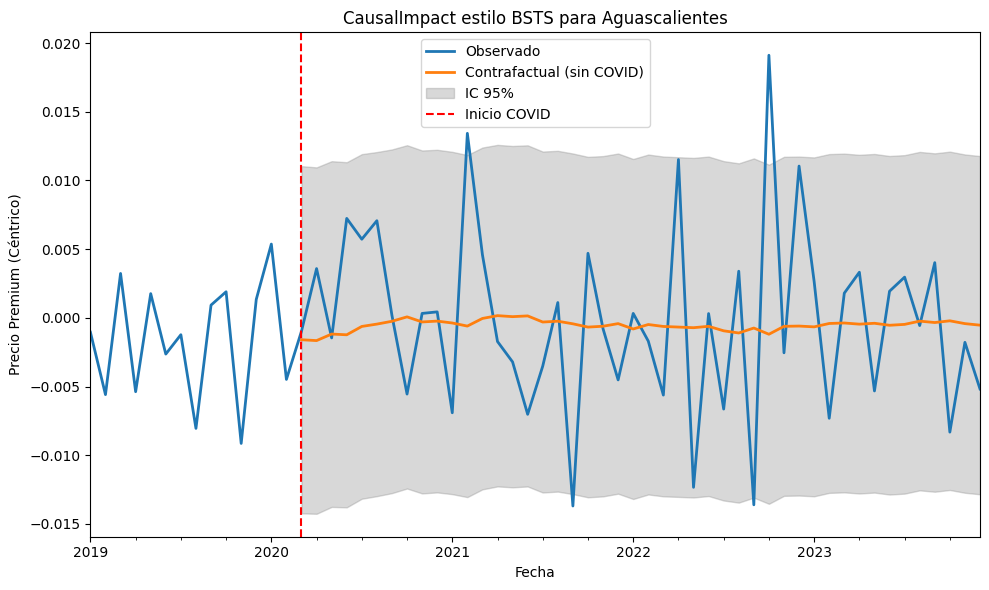

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents

# --- 1) Prepara tus datos -------------------------------------------------

# df_ci: tu DataFrame pivotado, índice 0..59, columnas Céntrico y Periférico.
# Asegúrate de tener un DateTimeIndex real si quieres axis de fechas:
# Si tu índice era integer, conviértelo a fechas reales:
# df_ci.index = pd.date_range(start='2019-01-01', periods=len(df_ci), freq='MS')

# Aíslalo a dos series numéricas limpias (sin NaN en todo el rango 0–59):
df_ci = df_ci[['Céntrico','Periférico']].dropna()
y    = df_ci['Céntrico']
x    = df_ci['Periférico']

# Define en qué punto “empieza el COVID” en tu índice posicional
# (ya lo calculaste: pre 0–13, post 14–59)
n_pre = 14
n_tot = len(df_ci)  # 60

# --- 2) Ajusta el modelo de espacio de estados ----------------------------

# Un modelo Local Level + regresor exógeno
mod = UnobservedComponents(
    endog=y,
    level='llevel',
    exog=x.to_frame(),
    freq='MS'               # mensual
)
res = mod.fit(disp=False)

print(res.summary())       # chequea coeficiente del regresor y varianza

# --- 3) Genera el contrafactual por forecast ------------------------------

# Preparamos el exógeno FUTURO (el x en post-período)
exog_future = x.iloc[n_pre:]  

# Forecast desde la primera fecha post-intervención hasta el final
# Convertimos posiciones a fechas si tu índice es datetime:
start_date = df_ci.index[n_pre]
end_date   = df_ci.index[-1]

pred = res.get_prediction(
    start=start_date,
    end=end_date,
    exog=exog_future.to_frame()  # debe ser DataFrame
)

# --- 4) Grafica Observado vs Contrafactual + bandas  -----------------------

fig, ax = plt.subplots(figsize=(10,6))

# Observado completo
y.plot(ax=ax, label='Observado', linewidth=2)

# Contrafactual (forecast)
pred.predicted_mean.plot(ax=ax, label='Contrafactual (sin COVID)', linewidth=2)

# Banda de confianza 95%
ci = pred.conf_int()
ax.fill_between(
    ci.index, 
    ci.iloc[:,0], 
    ci.iloc[:,1], 
    color='gray', alpha=0.3,
    label='IC 95%'
)

# Línea vertical en intervención
ax.axvline(start_date, color='red', linestyle='--', label='Inicio COVID')

ax.set_title(f'CausalImpact estilo BSTS para {nombre_estado}')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio Premium (Céntrico)')
ax.legend()
plt.tight_layout()
plt.show()

In [150]:
print(df_ci_causal['y'].std(), df_ci_causal['x1'].std())
print(df_ci_causal.corr())

0.0062349295811575224 0.009713113618145981
           y        x1
y   1.000000  0.016589
x1  0.016589  1.000000


In [157]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents

resultados_estado = []

# Define el periodo pre y post (ajusta según tu data)
n_pre = 14  # Por ejemplo, 14 meses pre-COVID (2019-01 a 2020-02)
for estado in series_zona_estado['state_id'].unique():
    nombre_estado = catalogo_estados.get(estado, f"Estado {estado}")
    df_estado = series_zona_estado[series_zona_estado['state_id'] == estado]
    # Pivot para obtener las dos zonas
    df_ci = df_estado.pivot(index='period', columns='zona', values='price_premium_mean').dropna()
    # Asegura que hay suficientes datos
    if {'Céntrico', 'Periférico'}.issubset(df_ci.columns) and len(df_ci) > n_pre + 10:
        # Index a fechas reales para mejor gráfico
        df_ci.index = pd.date_range(start='2019-01-01', periods=len(df_ci), freq='MS')
        y = df_ci['Céntrico']
        x = df_ci['Periférico']
        # Ajusta modelo
        mod = UnobservedComponents(endog=y, level='llevel', exog=x.to_frame())
        res = mod.fit(disp=False)
        # Forecast contrafactual en post
        exog_future = x.iloc[n_pre:]
        start_date = df_ci.index[n_pre]
        end_date = df_ci.index[-1]
        pred = res.get_prediction(start=start_date, end=end_date, exog=exog_future.to_frame())
        # Calcula efecto causal
        efecto = y.iloc[n_pre:] - pred.predicted_mean
        efecto_promedio = efecto.mean()
        efecto_total = efecto.sum()
        # IC promedio
        ci = pred.conf_int()
        lower = (y.iloc[n_pre:] < ci.iloc[:, 0]).sum()
        upper = (y.iloc[n_pre:] > ci.iloc[:, 1]).sum()
        # Interpretación automática
        if (lower + upper) / len(efecto) > 0.5:
            interpretacion = "Efecto causal significativo: el observado está fuera del IC del contrafactual en más de la mitad del periodo post."
        else:
            interpretacion = "No hay evidencia robusta de un efecto causal significativo en el periodo post."
        # Guarda resultados
        resultados_estado.append({
            'state_id': estado,
            'nombre_estado': nombre_estado,
            'efecto_promedio': efecto_promedio,
            'efecto_total': efecto_total,
            'interpretacion': interpretacion
        })
        # Guarda gráfico
        fig, ax = plt.subplots(figsize=(10,6))
        y.plot(ax=ax, label='Observado', linewidth=2)
        pred.predicted_mean.plot(ax=ax, label='Contrafactual (sin COVID)', linewidth=2)
        ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=0.3, label='IC 95%')
        ax.axvline(start_date, color='red', linestyle='--', label='Inicio COVID')
        ax.set_title(f'CausalImpact estilo BSTS para {nombre_estado}')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Precio Premium (Céntrico)')
        ax.legend()
        plt.tight_layout()
        plt.savefig(f'impacto_causal_{nombre_estado}.png')
        plt.close()
    else:
        resultados_estado.append({
            'state_id': estado,
            'nombre_estado': nombre_estado,
            'efecto_promedio': None,
            'efecto_total': None,
            'interpretacion': 'No hay suficientes datos para análisis robusto.'
        })

# Exporta resultados a Excel
df_resultados = pd.DataFrame(resultados_estado)
df_resultados.to_excel('impacto_causal_estados.xlsx', index=False)
print(df_resultados)

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


    state_id        nombre_estado  efecto_promedio  efecto_total  \
0          1       Aguascalientes         0.000336      0.015451   
1          2      Baja California              NaN           NaN   
2          3  Baja California Sur         0.001120      0.051536   
3          4             Campeche        -0.001321     -0.046240   
4          5             Coahuila         0.000870      0.040001   
5          6               Colima         0.000592      0.026652   
6          7              Chiapas        -0.002614     -0.120233   
7          8            Chihuahua        -0.001372     -0.063134   
8          9                 CDMX        -0.000732     -0.033668   
9         10              Durango        -0.000835     -0.038424   
10        11           Guanajuato         0.009645      0.443670   
11        12             Guerrero              NaN           NaN   
12        13              Hidalgo        -0.000909     -0.041822   
13        14              Jalisco        -0.0003

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.structural import UnobservedComponents
from scipy.stats import zscore

resultados_estado = []
logs_estado = []

# Parámetros mínimos recomendados
MIN_PRE = 12
MIN_POST = 12
MIN_TOTAL = MIN_PRE + MIN_POST

zonas_control = ['Periférico', 'Intermedio']

for estado in series_zona_estado['state_id'].unique():
    nombre_estado = catalogo_estados.get(estado, f"Estado {estado}")
    df_estado = series_zona_estado[series_zona_estado['state_id'] == estado]
    df_ci = df_estado.pivot(index='period', columns='zona', values='price_premium_mean')
    df_ci = df_ci.sort_index().dropna()
    log = {'state_id': estado, 'nombre_estado': nombre_estado}
    try:
        # --- Validación de calidad y suficiencia de datos ---
        # 1. Elimina outliers extremos usando z-score por zona
        df_ci = df_ci[(np.abs(zscore(df_ci, nan_policy='omit')) < 5).all(axis=1)]
        # 2. Sin NaNs
        df_ci = df_ci.dropna()
        # 3. Suficiencia de datos
        if len(df_ci) < MIN_TOTAL:
            interpretacion = 'No hay suficientes datos para análisis robusto.'
            log['error'] = 'Insuficientes observaciones'
            raise ValueError(interpretacion)
        # --- Ajuste flexible de parámetros por estado ---
        # 4. Periodos pre y post adaptativos: busca el corte más cercano a 2020-03
        corte = df_ci.index.get_loc(df_ci.index[df_ci.index >= '2020-03-01'][0])
        n_pre = corte
        n_post = len(df_ci) - corte
        if n_pre < MIN_PRE or n_post < MIN_POST:
            interpretacion = 'No hay suficientes datos pre o post intervención.'
            log['error'] = 'Insuficiente pre/post'
            raise ValueError(interpretacion)
        # 5. Selección automática de control: prueba Periférico, luego Intermedio
        control_usado = None
        for zona_control in zonas_control:
            if {'Céntrico', zona_control}.issubset(df_ci.columns):
                y = df_ci['Céntrico']
                x = df_ci[zona_control]
                # Chequea correlación pre-intervención
                corr = y.iloc[:n_pre].corr(x.iloc[:n_pre])
                log[f'corr_{zona_control}'] = corr
                if abs(corr) >= 0.2 and x.iloc[:n_pre].std() > 0:
                    control_usado = zona_control
                    break
        if control_usado is None:
            interpretacion = 'No hay correlación suficiente entre zonas para análisis causal robusto.'
            log['error'] = 'Baja correlación control'
            raise ValueError(interpretacion)
        # --- Diagnóstico y reporte automático de robustez ---
        # 6. Modelado de espacio de estados
        y = y.reset_index(drop=True)
        x = x.reset_index(drop=True)
        mod = UnobservedComponents(endog=y, level='llevel', exog=x.to_frame())
        res = mod.fit(disp=False)
        exog_future = x.iloc[n_pre:]
        pred = res.get_prediction(start=n_pre, end=len(df_ci)-1, exog=exog_future.to_frame())
        efecto = y.iloc[n_pre:] - pred.predicted_mean
        efecto_promedio = efecto.mean()
        efecto_total = efecto.sum()
        ci = pred.conf_int()
        lower = (y.iloc[n_pre:] < ci.iloc[:, 0]).sum()
        upper = (y.iloc[n_pre:] > ci.iloc[:, 1]).sum()
        pct_fuera_ic = (lower + upper) / len(efecto)
        # --- Interpretación automática y validación cruzada ---
        umbral_significancia = 0.01 * y.mean()  # 1% del precio promedio
        if pct_fuera_ic > 0.5 and abs(efecto_promedio) > umbral_significancia:
            interpretacion = "Efecto causal robusto: el observado está fuera del IC del contrafactual en más de la mitad del periodo post y el efecto supera el 1% del precio promedio."
        else:
            interpretacion = "No hay evidencia robusta de un efecto causal significativo en el periodo post."
        # --- Documentación y transparencia ---
        log.update({
            'n_total': len(df_ci),
            'n_pre': n_pre,
            'n_post': n_post,
            'control_usado': control_usado,
            'efecto_promedio': efecto_promedio,
            'efecto_total': efecto_total,
            'pct_fuera_ic': pct_fuera_ic,
            'interpretacion': interpretacion
        })
        # Guarda gráfico
        fig, ax = plt.subplots(figsize=(10,6))
        y.plot(ax=ax, label='Observado', linewidth=2)
        pred.predicted_mean.plot(ax=ax, label='Contrafactual (sin COVID)', linewidth=2)
        ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=0.3, label='IC 95%')
        ax.axvline(y.index[n_pre], color='red', linestyle='--', label='Inicio COVID')
        ax.set_title(f'CausalImpact estilo BSTS para {nombre_estado}')
        ax.set_xlabel('Fecha')
        ax.set_ylabel('Precio Premium (Céntrico)')
        ax.legend()
        plt.tight_layout()
        plt.savefig(f'impacto_causal_{nombre_estado}.png')
        plt.close()
    except Exception as e:
        log['error'] = str(e)
        interpretacion = f"No robusto: {str(e)}"
        log['interpretacion'] = interpretacion
        efecto_promedio = None
        efecto_total = None
        pct_fuera_ic = None
    resultados_estado.append({
        'state_id': estado,
        'nombre_estado': nombre_estado,
        'efecto_promedio': efecto_promedio,
        'efecto_total': efecto_total,
        'pct_fuera_ic': pct_fuera_ic,
        'interpretacion': interpretacion
    })
    logs_estado.append(log)

# Exporta resultados y logs
df_resultados = pd.DataFrame(resultados_estado)
df_resultados.to_excel('impacto_causal_estados.xlsx', index=False)
df_logs = pd.DataFrame(logs_estado)
df_logs.to_excel('logs_causal_estados.xlsx', index=False)
print(df_resultados)

/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniconda/base/envs/real_estate_mx_otis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


    state_id        nombre_estado  efecto_promedio  efecto_total  \
0          1       Aguascalientes         0.000336      0.015451   
1          2      Baja California              NaN           NaN   
2          3  Baja California Sur              NaN           NaN   
3          4             Campeche              NaN           NaN   
4          5             Coahuila              NaN           NaN   
5          6               Colima         0.000729      0.032792   
6          7              Chiapas        -0.002614     -0.120233   
7          8            Chihuahua              NaN           NaN   
8          9                 CDMX        -0.000732     -0.033668   
9         10              Durango        -0.000866     -0.039816   
10        11           Guanajuato              NaN           NaN   
11        12             Guerrero              NaN           NaN   
12        13              Hidalgo              NaN           NaN   
13        14              Jalisco        -0.0001

In [160]:
series_zona_estado['period'] = pd.to_datetime(series_zona_estado['period'])

In [161]:
fecha_corte = pd.Timestamp('2020-03-01')

In [162]:
import pandas as pd

resultados = []

for estado in series_zona_estado['state_id'].unique():
    for zona in ['Céntrico', 'Intermedio', 'Periférico']:
        df_sub = series_zona_estado[(series_zona_estado['state_id'] == estado) & (series_zona_estado['zona'] == zona)]
        if len(df_sub) == 0:
            continue
        pre = df_sub[df_sub['period'] < fecha_corte]
        post = df_sub[df_sub['period'] >= fecha_corte]
        # Solo si hay datos suficientes
        if len(pre) >= 6 and len(post) >= 6:
            pre_vol = pre['volume'].mean()
            post_vol = post['volume'].mean()
            pre_prem = pre['price_premium_mean'].mean()
            post_prem = post['price_premium_mean'].mean()
            resultados.append({
                'state_id': estado,
                'zona': zona,
                'delta_vol': post_vol - pre_vol,
                'pct_delta_vol': (post_vol - pre_vol) / pre_vol if pre_vol else None,
                'delta_prem': post_prem - pre_prem,
                'pre_vol': pre_vol,
                'post_vol': post_vol,
                'pre_prem': pre_prem,
                'post_prem': post_prem
            })

df_resultados = pd.DataFrame(resultados)

In [163]:
# Top caídas en volumen
print(df_resultados.sort_values('pct_delta_vol').head(10))

# Top aumentos en volumen
print(df_resultados.sort_values('pct_delta_vol', ascending=False).head(10))

# Top caídas en precio premium
print(df_resultados.sort_values('delta_prem').head(10))

    state_id        zona   delta_vol  pct_delta_vol  delta_prem     pre_vol  \
91        32  Periférico  -42.934783      -0.533351   -0.004537   80.500000   
29        11  Intermedio  -15.180124      -0.415082   -0.008071   36.571429   
54        20  Intermedio  -16.658385      -0.329403   -0.001910   50.571429   
55        20  Periférico   -1.990033      -0.302831   -0.010799    6.571429   
63        23  Intermedio -132.673913      -0.299490   -0.000818  443.000000   
26        10  Intermedio  -32.903727      -0.296049    0.001204  111.142857   
48        18  Intermedio  -15.739130      -0.271364   -0.001532   58.000000   
15         6  Periférico  -38.819876      -0.234662    0.001064  165.428571   
6          3  Periférico  -33.344720      -0.230418    0.002920  144.714286   
0          1    Céntrico  -57.838509      -0.228934    0.001437  252.642857   

      post_vol  pre_prem  post_prem  
91   37.565217  0.001533  -0.003005  
29   21.391304 -0.000064  -0.008135  
54   33.913043 -

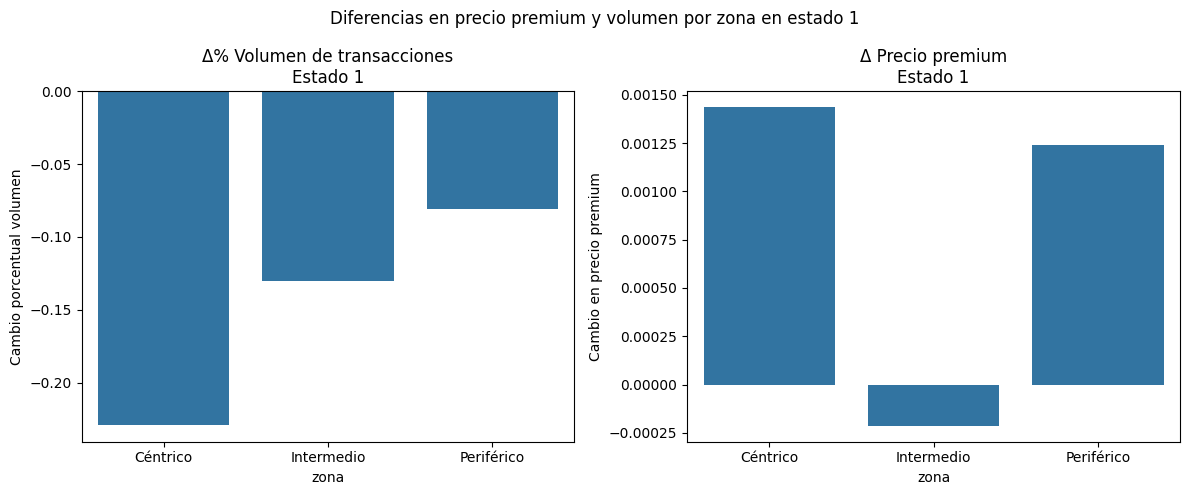

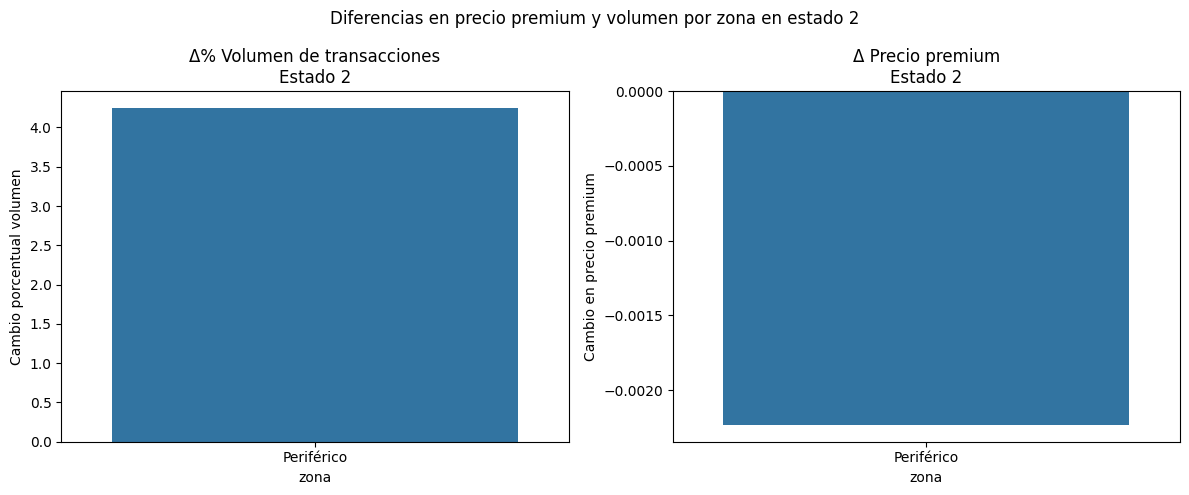

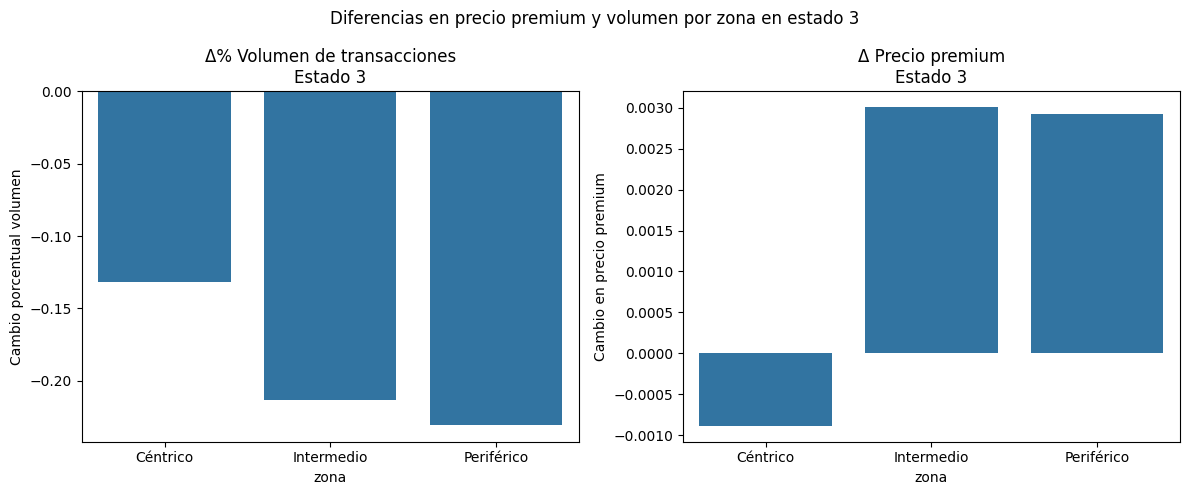

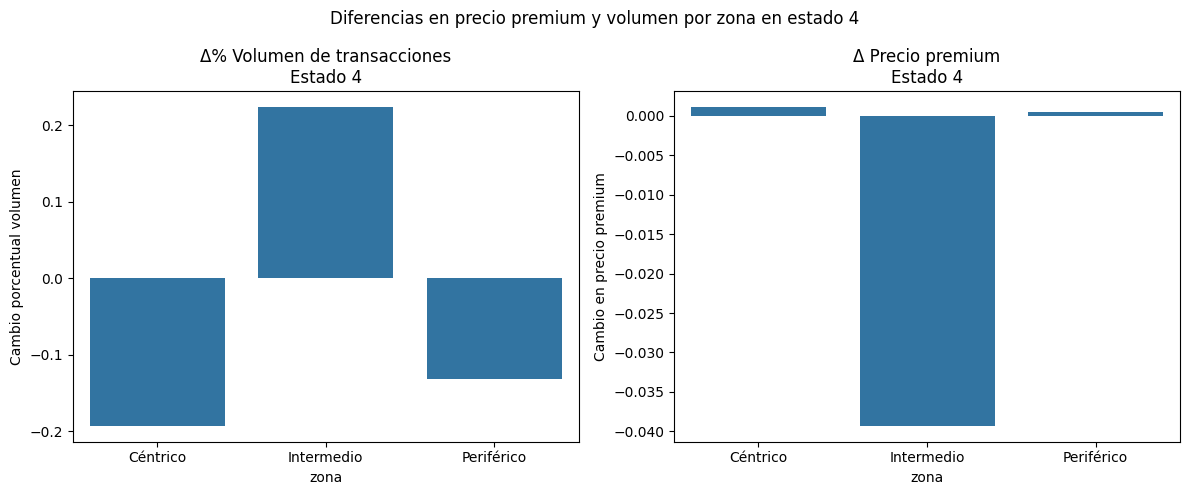

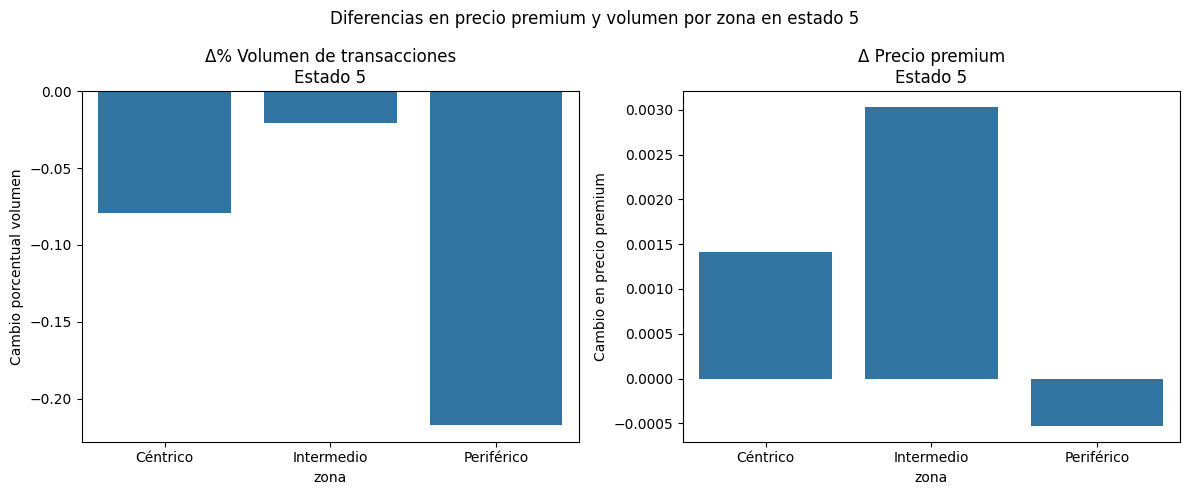

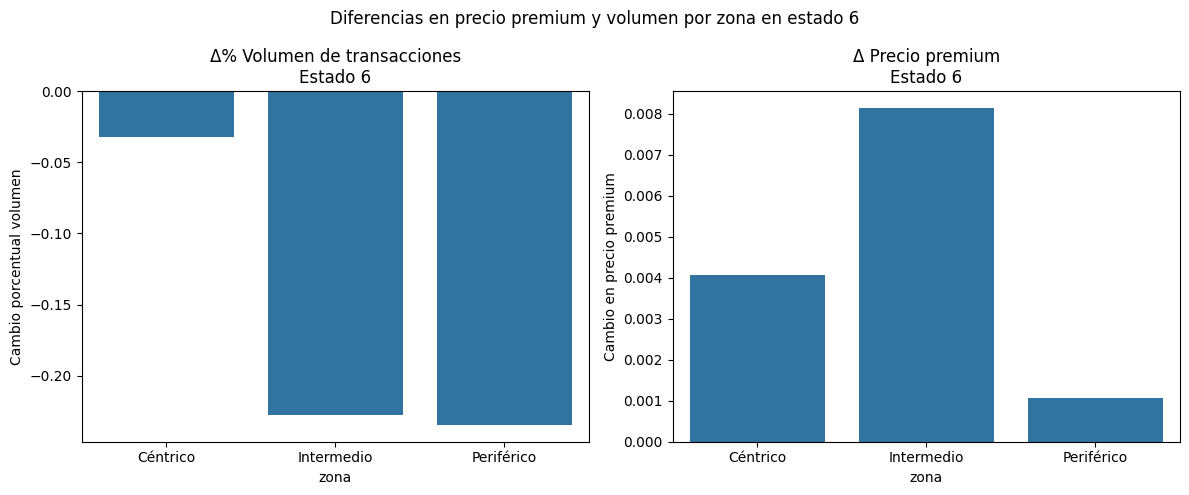

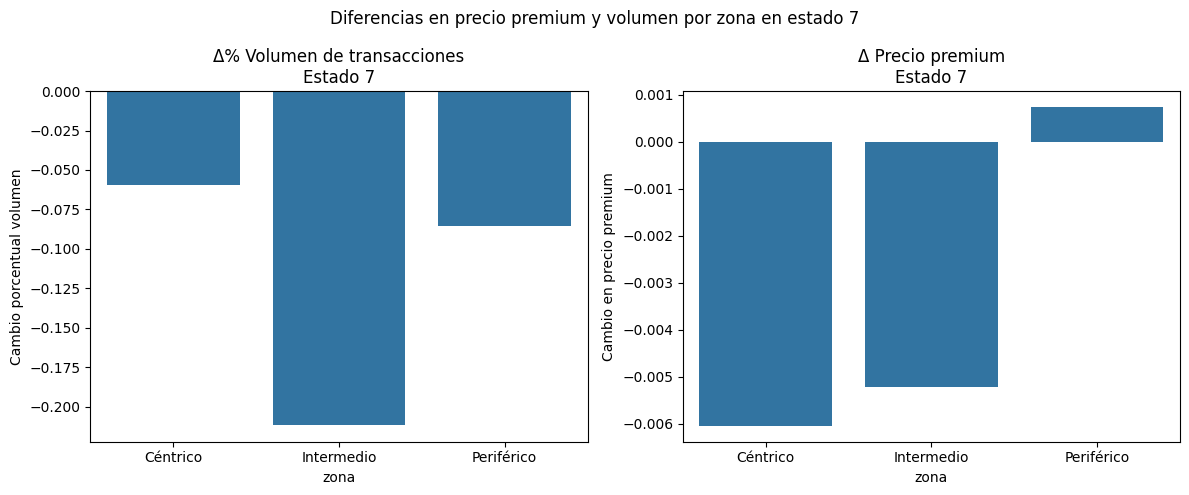

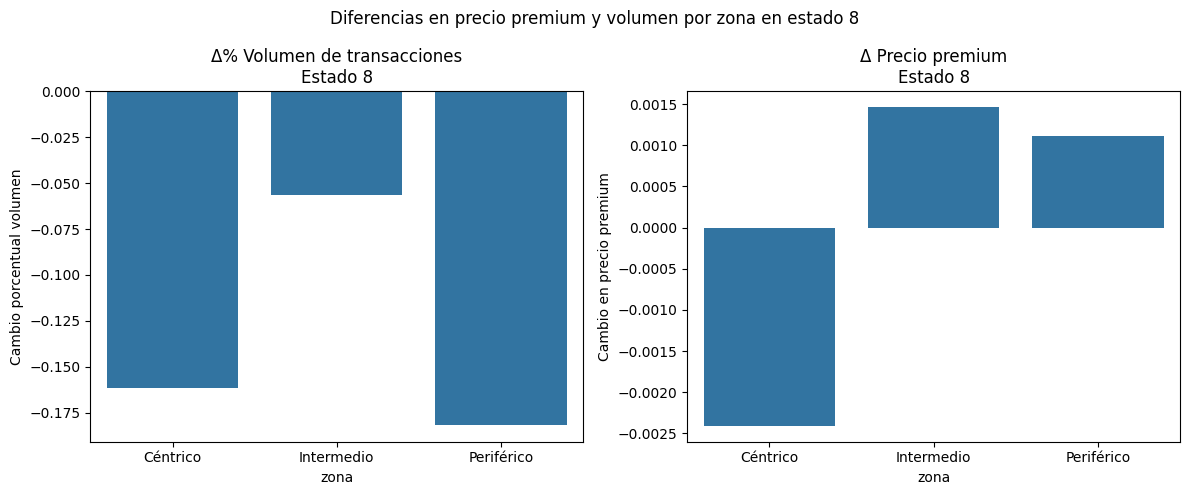

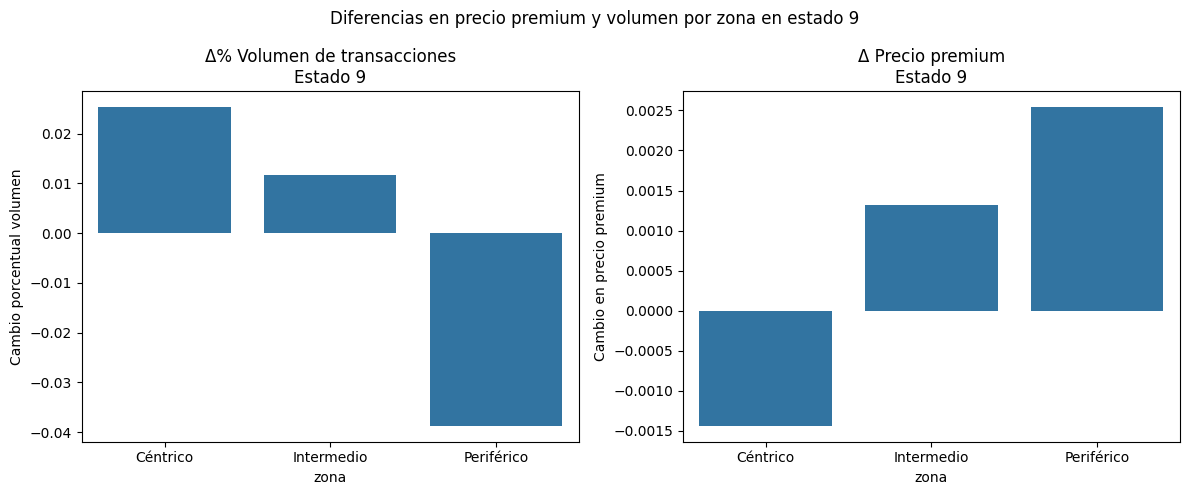

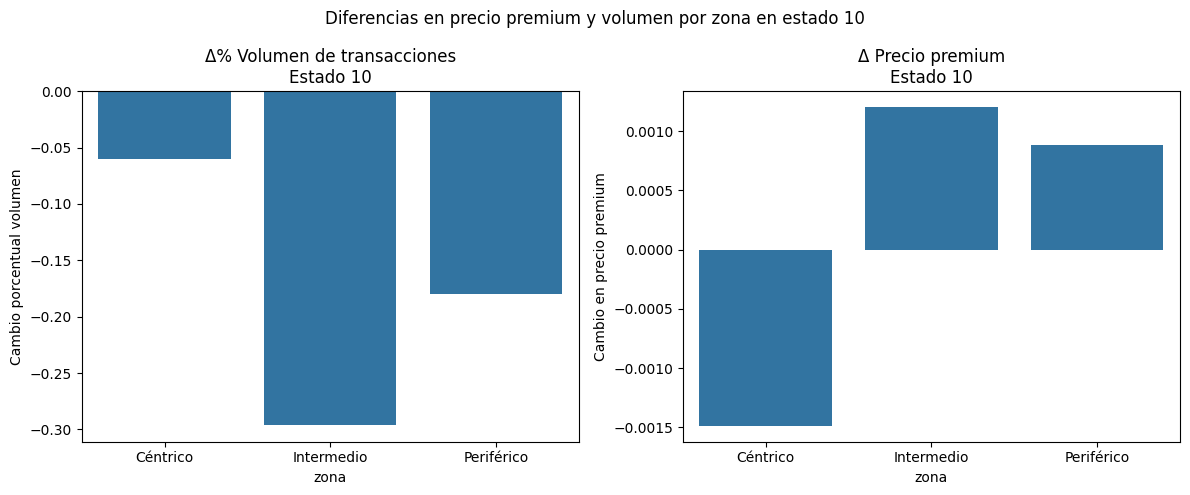

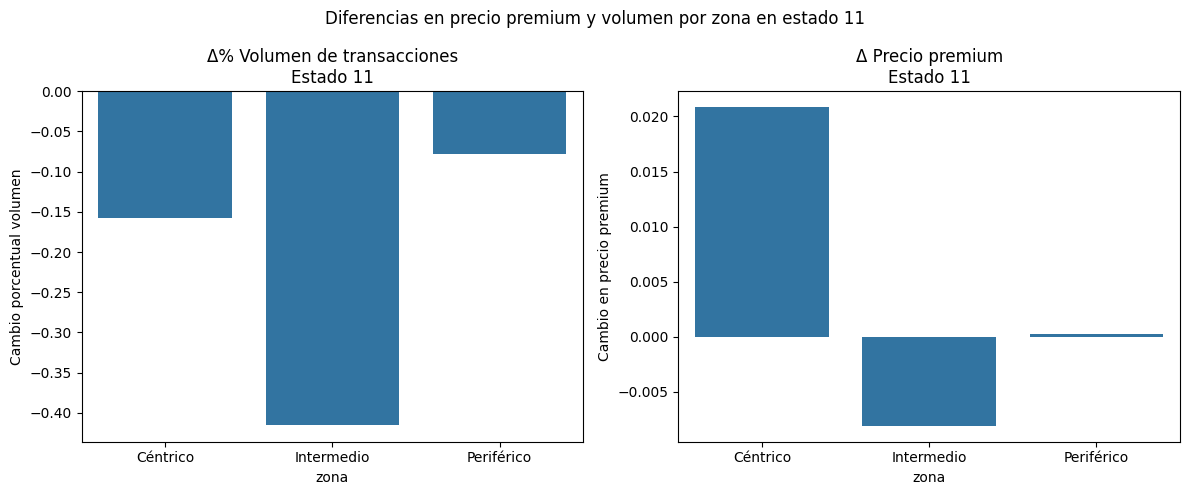

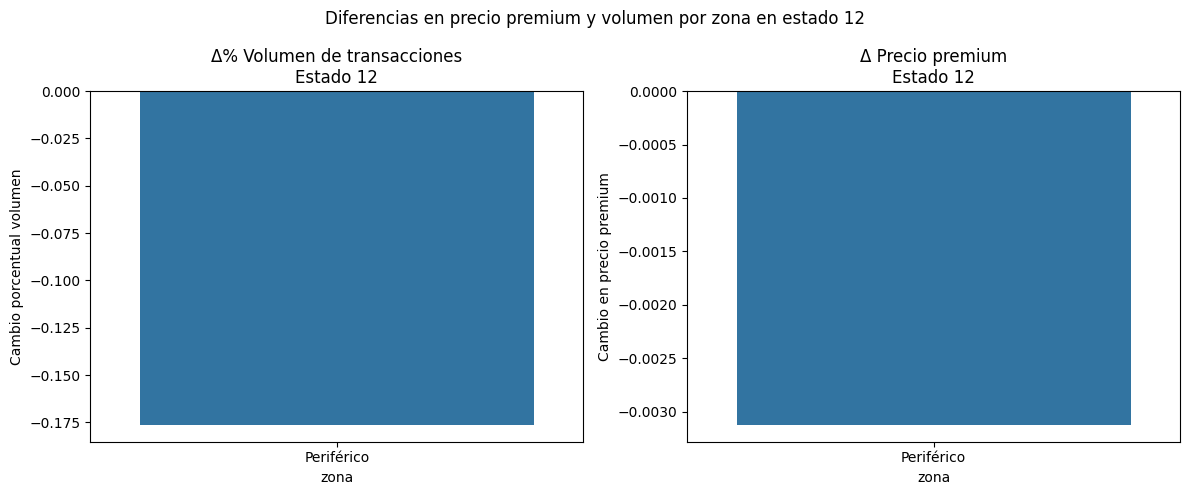

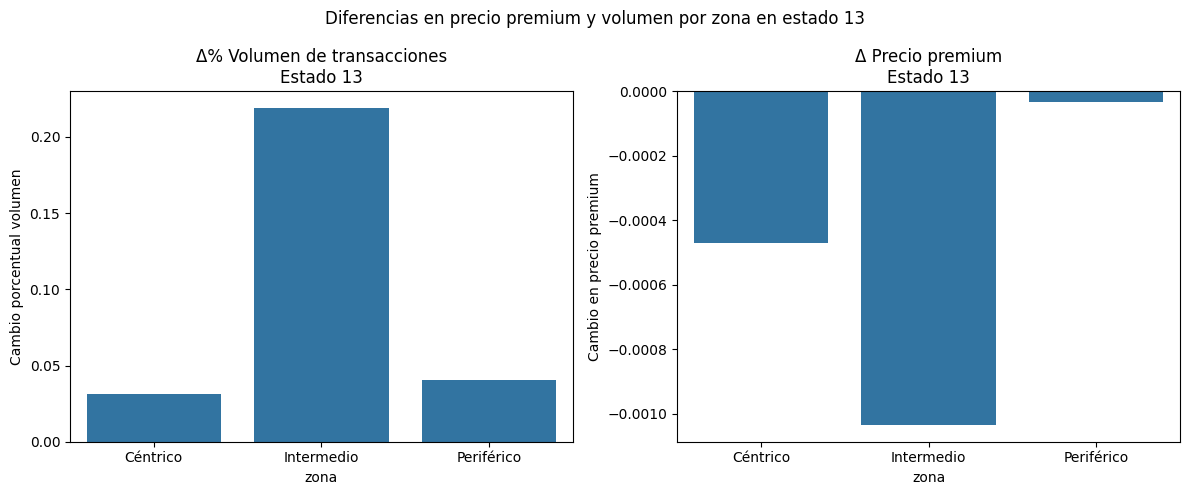

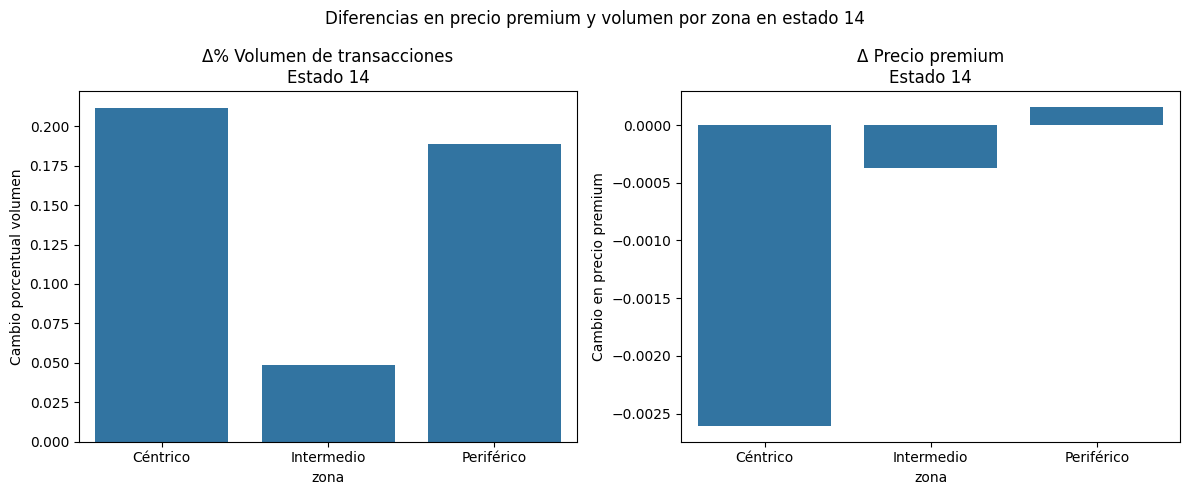

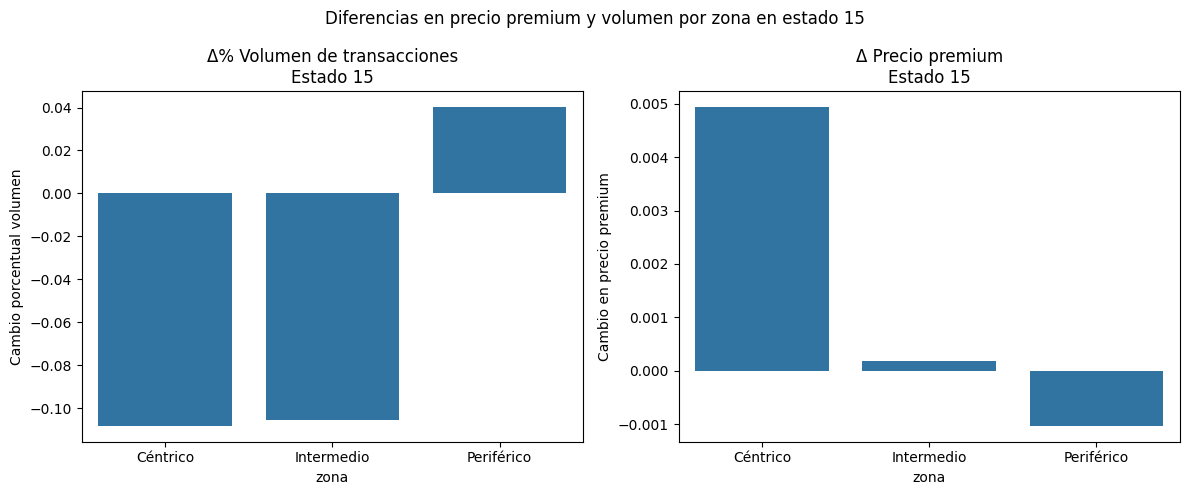

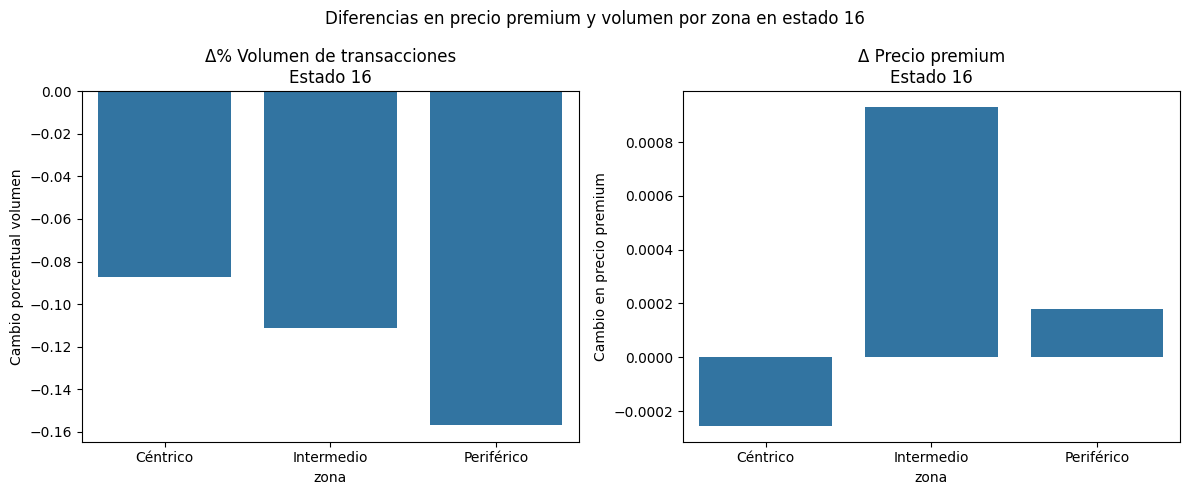

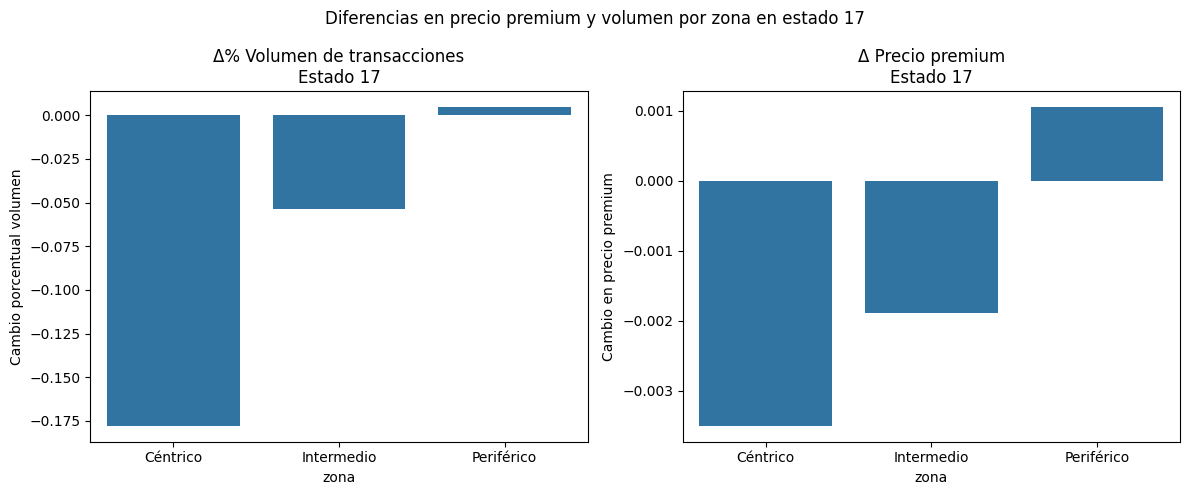

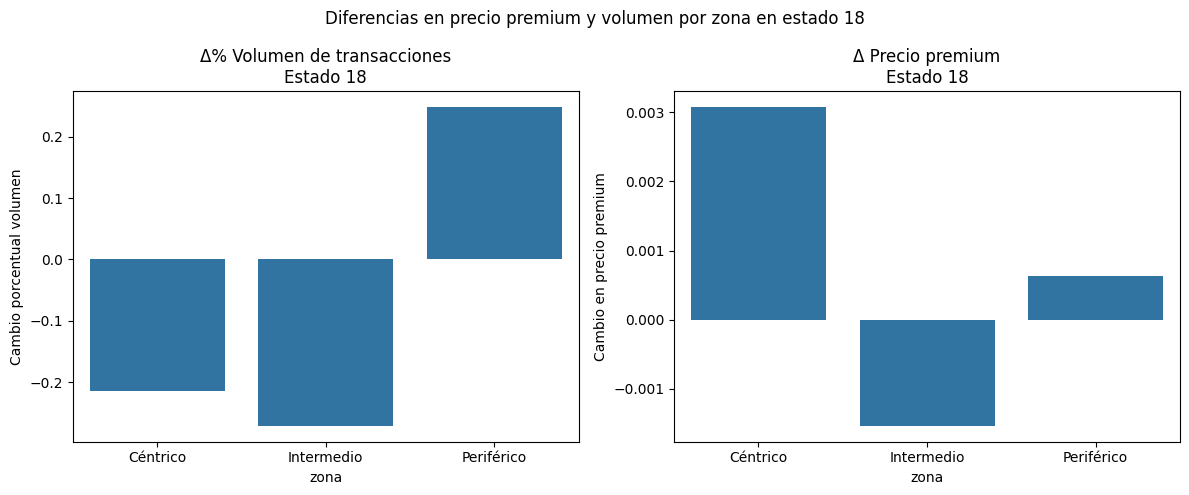

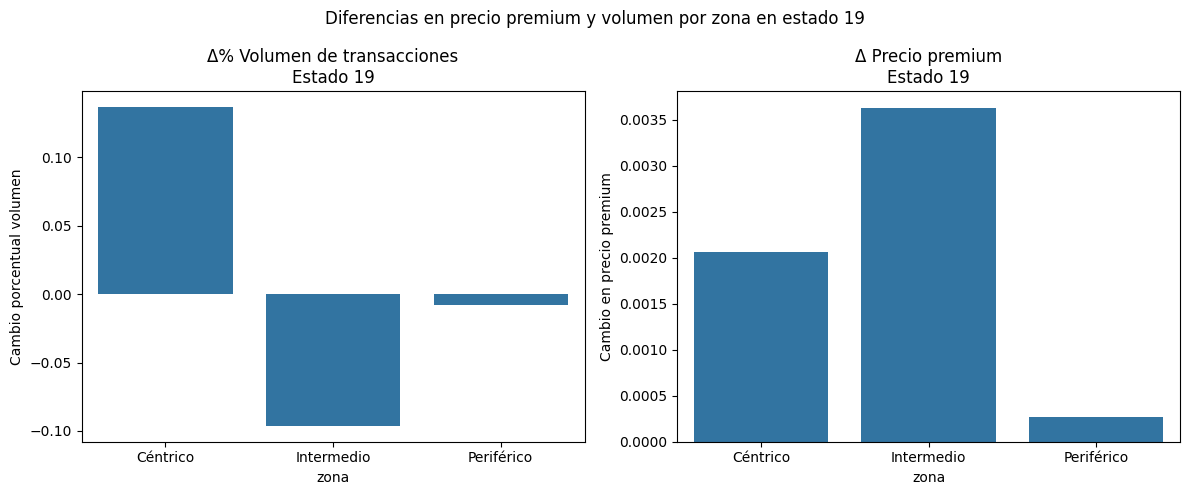

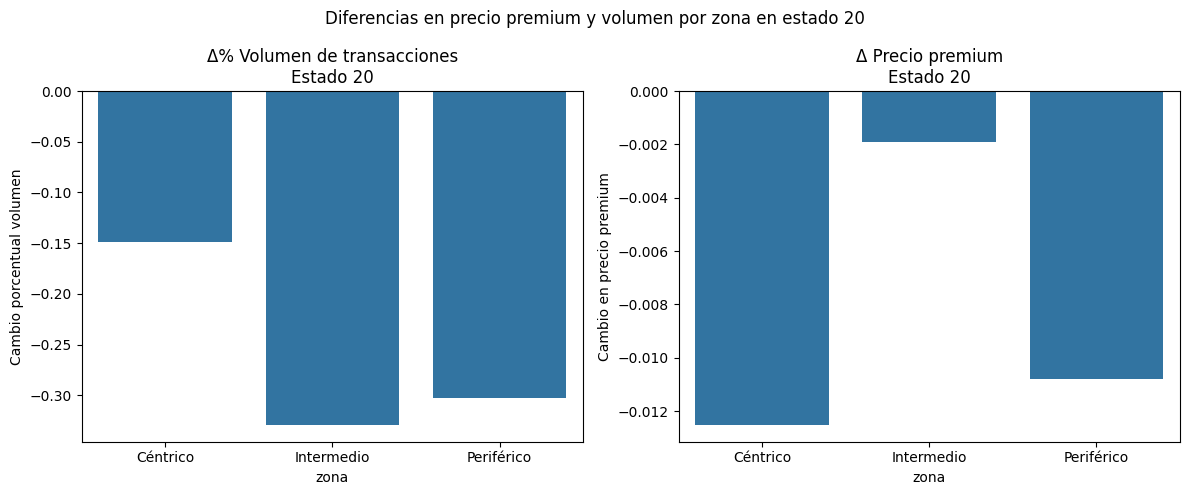

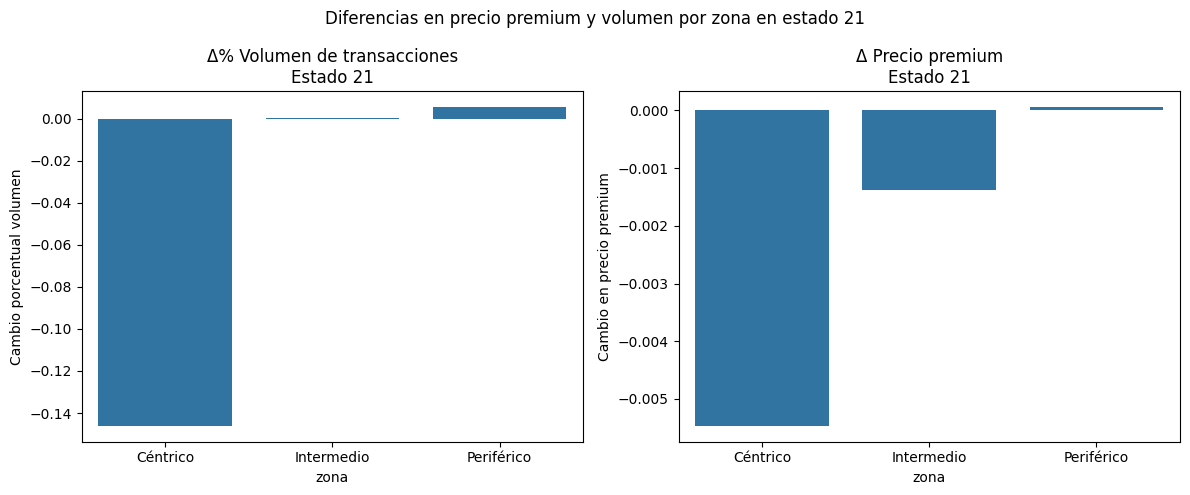

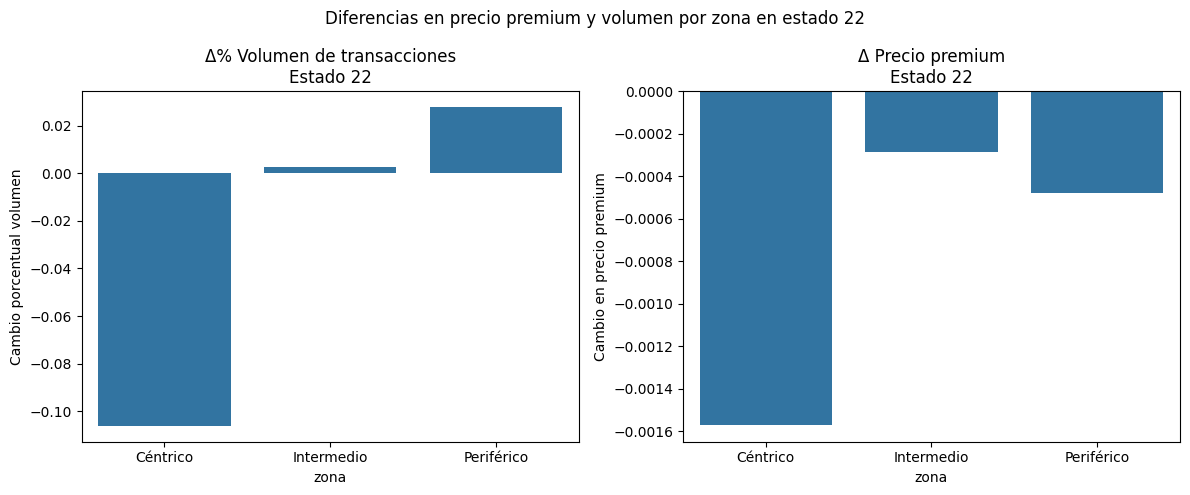

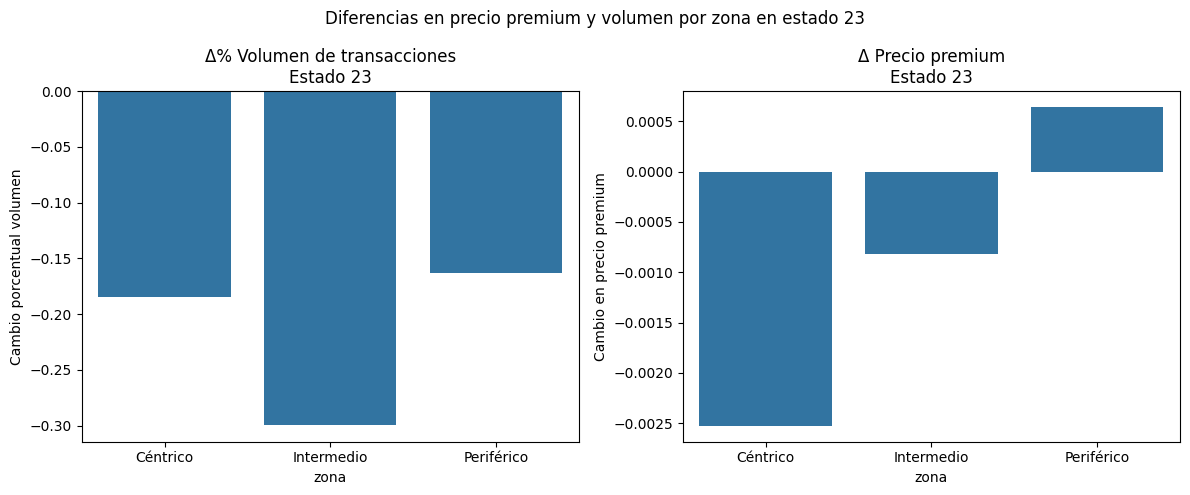

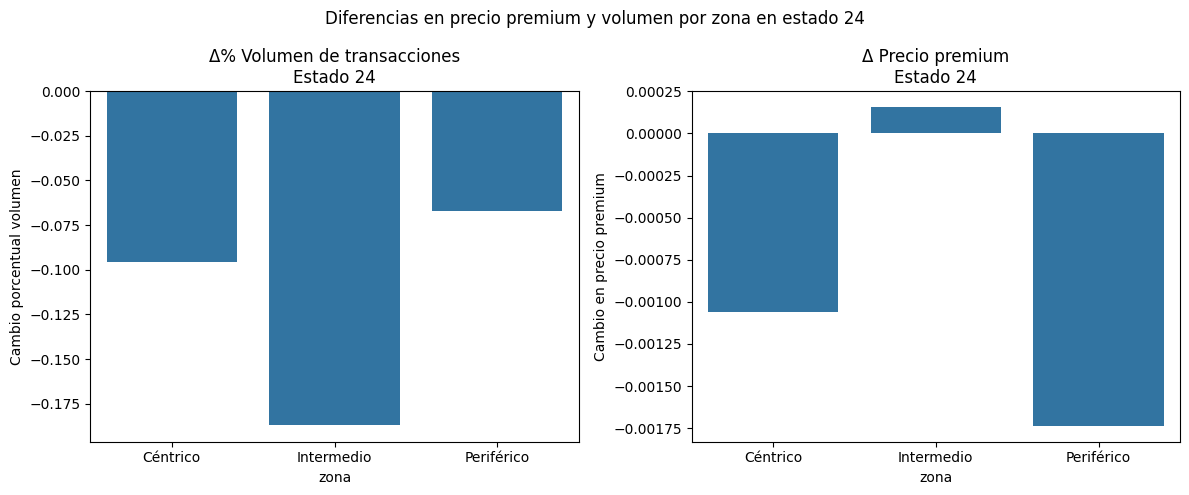

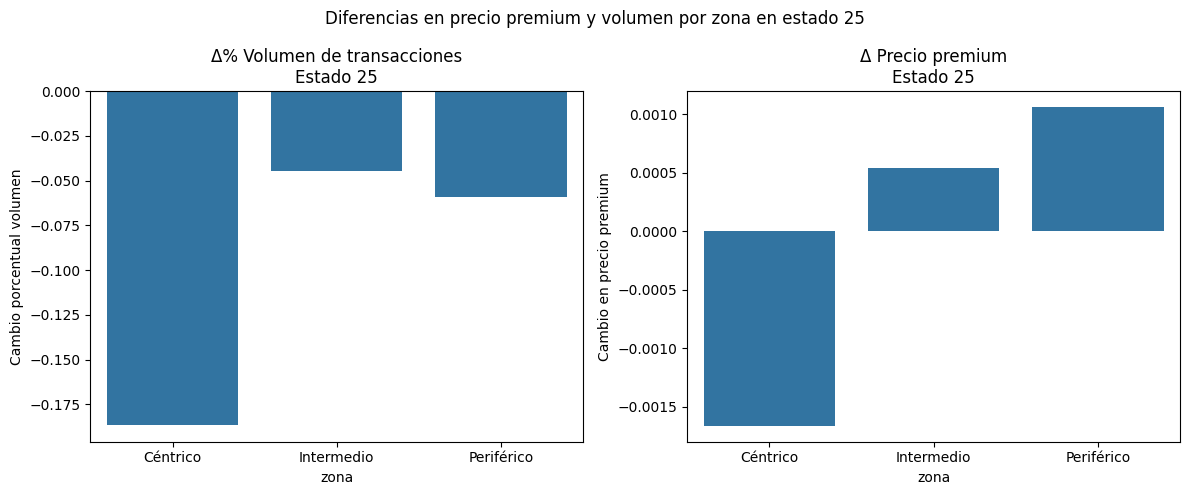

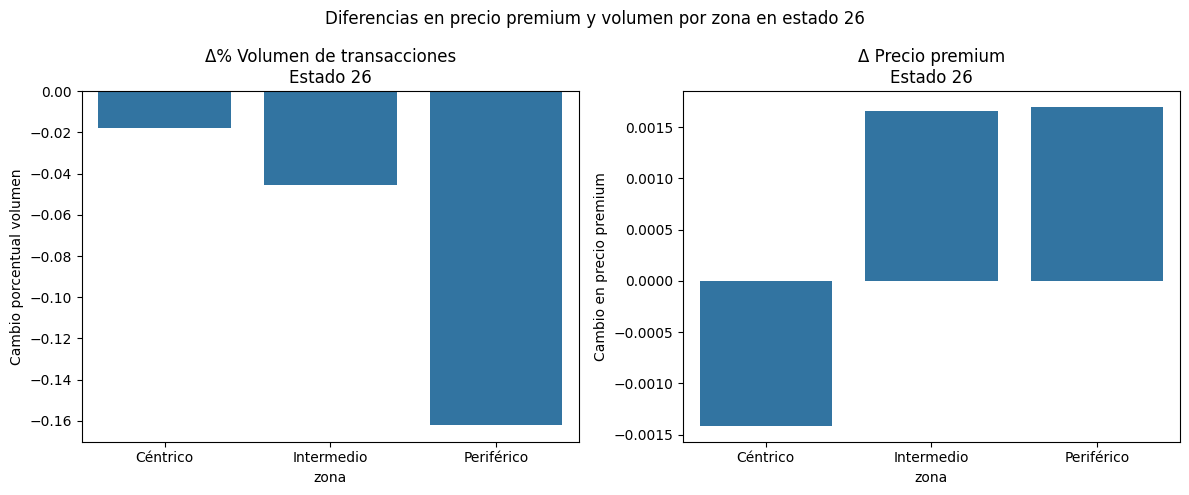

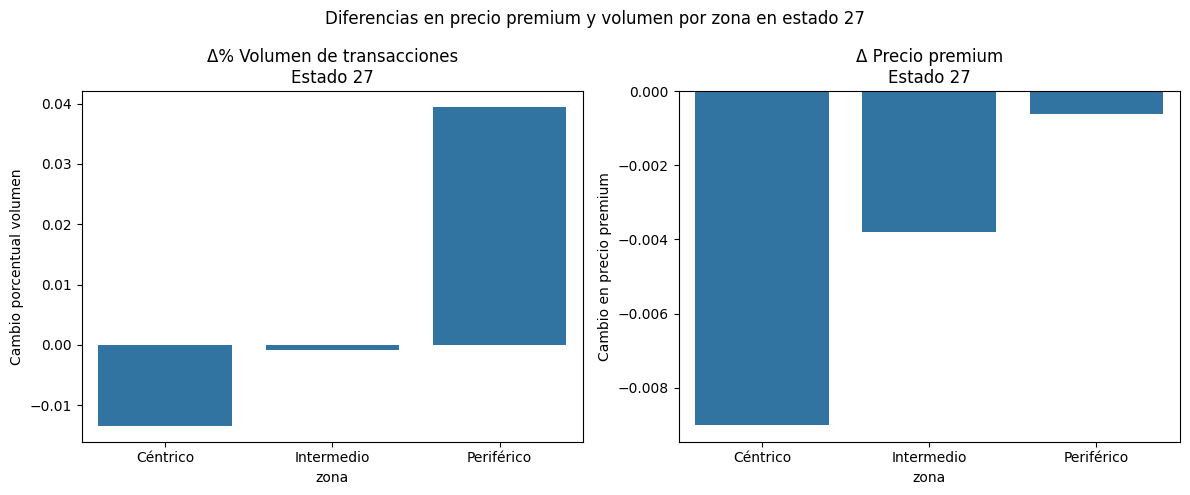

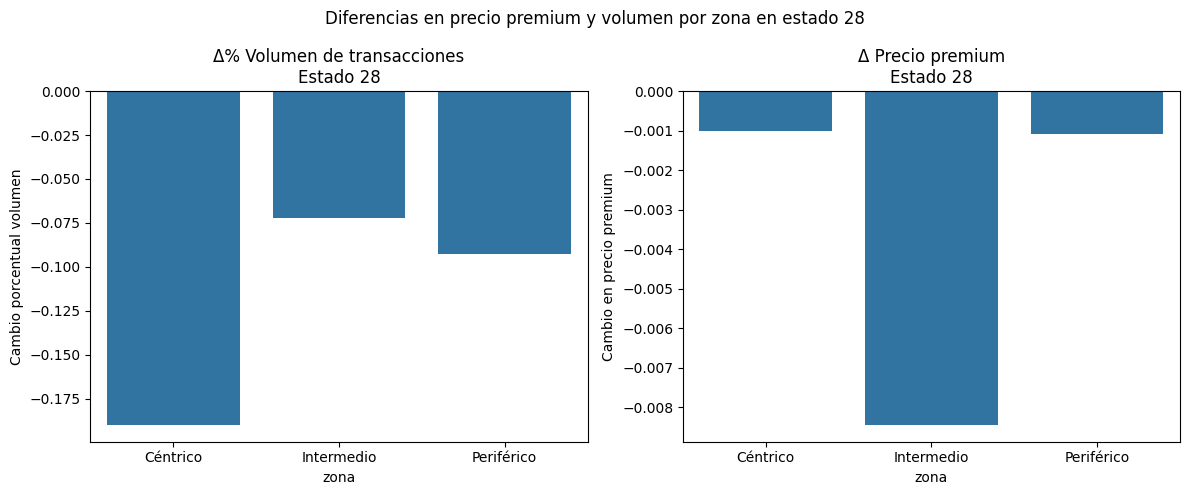

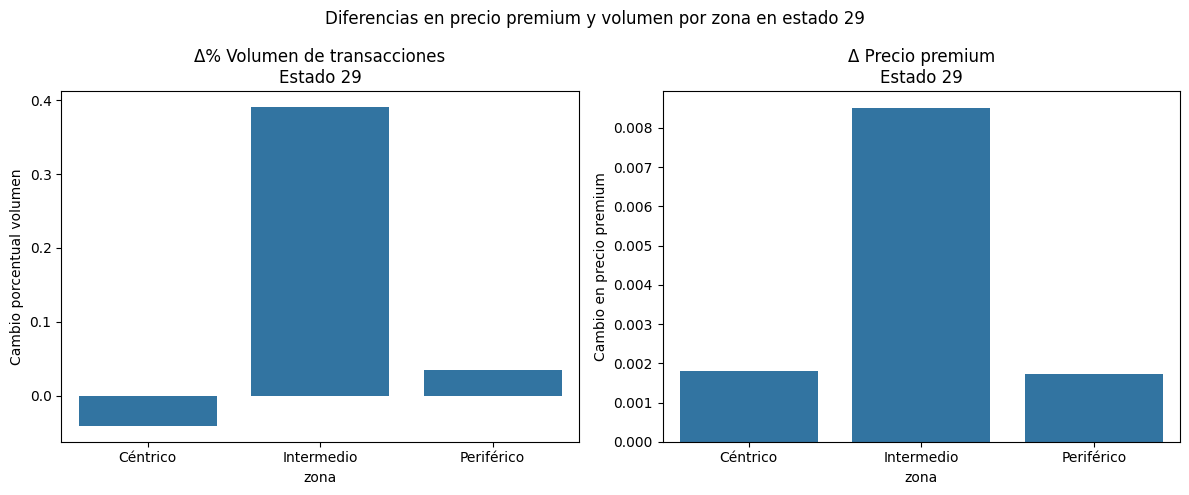

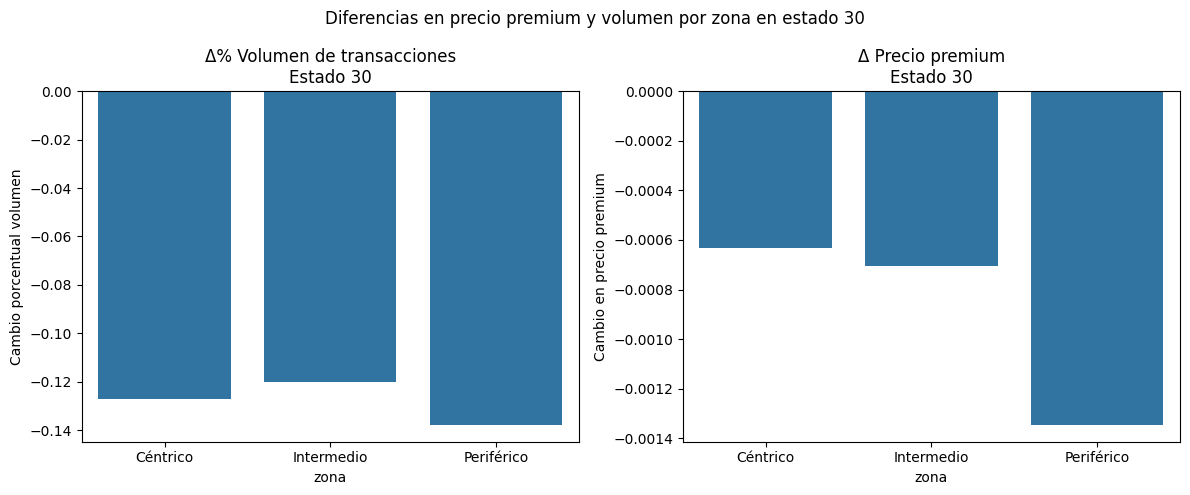

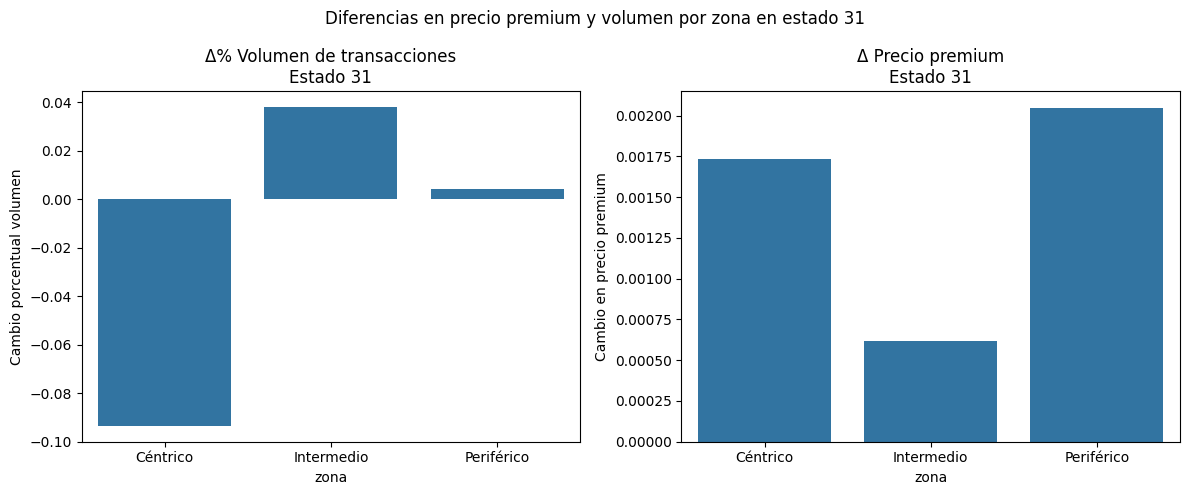

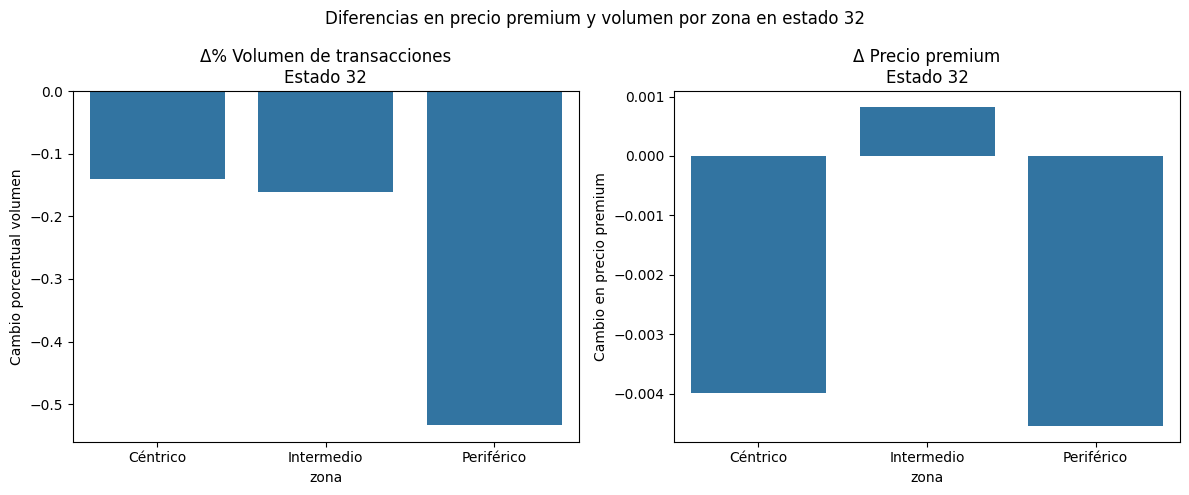

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

for estado in df_resultados['state_id'].unique():
    df_plot = df_resultados[df_resultados['state_id'] == estado]
    if df_plot.empty:
        continue
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.barplot(data=df_plot, x='zona', y='pct_delta_vol', ax=axes[0])
    axes[0].set_title(f'Δ% Volumen de transacciones\nEstado {estado}')
    axes[0].set_ylabel('Cambio porcentual volumen')
    sns.barplot(data=df_plot, x='zona', y='delta_prem', ax=axes[1])
    axes[1].set_title(f'Δ Precio premium\nEstado {estado}')
    axes[1].set_ylabel('Cambio en precio premium')
    plt.suptitle(f'Diferencias en precio premium y volumen por zona en estado {estado}')
    plt.tight_layout()
    plt.show()


In [165]:
tabla_nacional = df_resultados.groupby('zona')[['delta_prem', 'pct_delta_vol']].mean().reset_index()
print(tabla_nacional)

         zona  delta_prem  pct_delta_vol
0    Céntrico   -0.000581      -0.092589
1  Intermedio   -0.001325      -0.084489
2  Periférico   -0.000211       0.048943


In [166]:
def interpreta(row):
    if row['pct_delta_vol'] is not None and row['pct_delta_vol'] < -0.2:
        return "Fuerte caída en volumen tras COVID-19"
    elif row['pct_delta_vol'] is not None and row['pct_delta_vol'] > 0.2:
        return "Recuperación o aumento en volumen tras COVID-19"
    else:
        return "Cambio moderado o estable en volumen"
df_resultados['interpretacion'] = df_resultados.apply(interpreta, axis=1)

In [167]:
df_resultados

state_id        zona   delta_vol  pct_delta_vol  delta_prem     pre_vol  \
0          1    Céntrico  -57.838509      -0.228934    0.001437  252.642857   
1          1  Intermedio  -75.394410      -0.130038   -0.000214  579.785714   
2          1  Periférico   -4.248447      -0.081144    0.001242   52.357143   
3          2  Periférico  474.167702       4.249903   -0.002233  111.571429   
4          3    Céntrico   -9.034161      -0.131611   -0.000884   68.642857   
..       ...         ...         ...            ...         ...         ...   
87        31  Intermedio   21.953416       0.038029    0.000620  577.285714   
88        31  Periférico    0.534161       0.004438    0.002048  120.357143   
89        32    Céntrico   -7.670807      -0.140198   -0.003979   54.714286   
90        32  Intermedio  -27.711180      -0.161178    0.000823  171.928571   
91        32  Periférico  -42.934783      -0.533351   -0.004537   80.500000   

      post_vol  pre_prem  post_prem  \
0   194.804348 -0.001643  -0.000206   
1   504.391304 -0.000754  -0.000968   
2    48.108696 -0.003284  -0.002042   
3   585.739130  0.002479   0.000246   
4    59.608696  0.000734  -0.000150   
..         ...       ...        ...   
87  599.239130 -0.001204  -0.000584   
88  120.891304 -0.002250  -0.000202   
89   47.043478  0.000497  -0.003483   
90  144.217391 -0.001422  -0.000599   
91   37.565217  0.001533  -0.003005   

                                     interpretacion  
0             Fuerte caída en volumen tras COVID-19  
1              Cambio moderado o estable en volumen  
2              Cambio moderado o estable en volumen  
3   Recuperación o aumento en volumen tras COVID-19  
4              Cambio moderado o estable en volumen  
..                                              ...  
87             Cambio moderado o estable en volumen  
88             Cambio moderado o estable en volumen  
89             Cambio moderado o estable en volumen  
90             Cambio moderado o estable en volumen  
91            Fuerte caída en volumen tras COVID-19  

[92 rows x 10 columns]

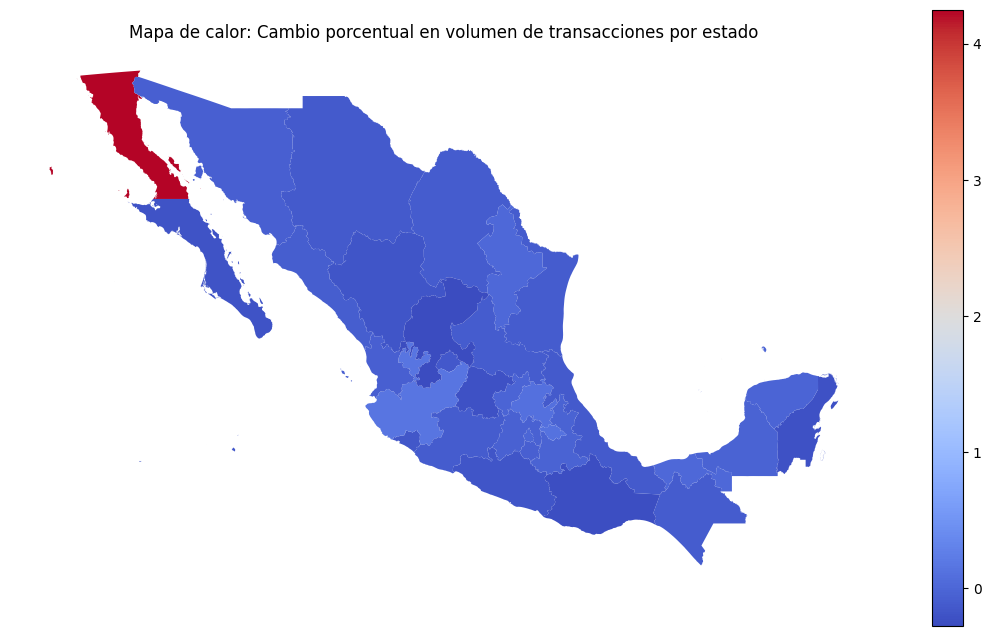

In [168]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Promedia el cambio por estado para un heatmap nacional
df_vol = df_resultados.groupby('state_id')['pct_delta_vol'].mean().reset_index()
gdf_plot = gdf_mex_states.merge(df_vol, on='state_id', how='left')

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
gdf_plot.plot(column='pct_delta_vol', cmap='coolwarm', legend=True, ax=ax,
              missing_kwds={'color': 'lightgrey', 'label': 'Sin datos'})
plt.title('Mapa de calor: Cambio porcentual en volumen de transacciones por estado')
plt.axis('off')
plt.show()

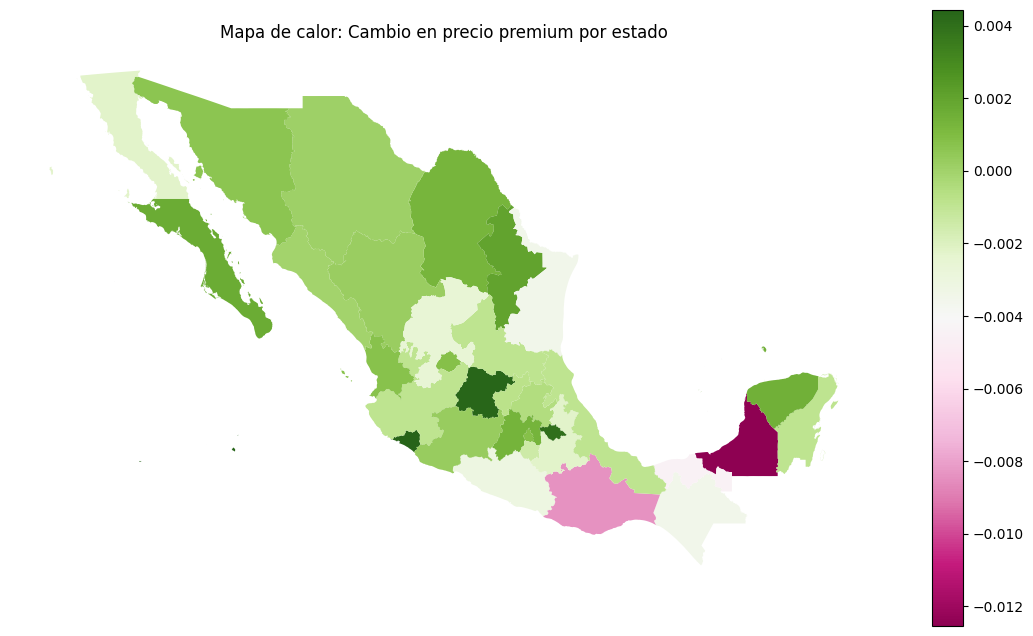

In [169]:
df_prem = df_resultados.groupby('state_id')['delta_prem'].mean().reset_index()
gdf_plot2 = gdf_mex_states.merge(df_prem, on='state_id', how='left')

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
gdf_plot2.plot(column='delta_prem', cmap='PiYG', legend=True, ax=ax,
               missing_kwds={'color': 'lightgrey', 'label': 'Sin datos'})
plt.title('Mapa de calor: Cambio en precio premium por estado')
plt.axis('off')
plt.show()

In [170]:
def interpreta_vol(row):
    if row['pct_delta_vol'] is not None:
        if row['pct_delta_vol'] < -0.2:
            return "Fuerte caída en volumen tras COVID-19"
        elif row['pct_delta_vol'] > 0.2:
            return "Recuperación o aumento en volumen tras COVID-19"
        else:
            return "Cambio moderado o estable en volumen"
    return "Sin datos"

def interpreta_prem(row):
    if row['delta_prem'] is not None:
        if abs(row['delta_prem']) > 0.01:
            return f"Efecto notable en precio premium ({row['delta_prem']:+.2%})"
        else:
            return "Cambio menor en precio premium"
    return "Sin datos"

df_resultados['interpretacion_vol'] = df_resultados.apply(interpreta_vol, axis=1)
df_resultados['interpretacion_prem'] = df_resultados.apply(interpreta_prem, axis=1)

In [171]:
df_resultados

state_id        zona   delta_vol  pct_delta_vol  delta_prem     pre_vol  \
0          1    Céntrico  -57.838509      -0.228934    0.001437  252.642857   
1          1  Intermedio  -75.394410      -0.130038   -0.000214  579.785714   
2          1  Periférico   -4.248447      -0.081144    0.001242   52.357143   
3          2  Periférico  474.167702       4.249903   -0.002233  111.571429   
4          3    Céntrico   -9.034161      -0.131611   -0.000884   68.642857   
..       ...         ...         ...            ...         ...         ...   
87        31  Intermedio   21.953416       0.038029    0.000620  577.285714   
88        31  Periférico    0.534161       0.004438    0.002048  120.357143   
89        32    Céntrico   -7.670807      -0.140198   -0.003979   54.714286   
90        32  Intermedio  -27.711180      -0.161178    0.000823  171.928571   
91        32  Periférico  -42.934783      -0.533351   -0.004537   80.500000   

      post_vol  pre_prem  post_prem  \
0   194.804348 -0.001643  -0.000206   
1   504.391304 -0.000754  -0.000968   
2    48.108696 -0.003284  -0.002042   
3   585.739130  0.002479   0.000246   
4    59.608696  0.000734  -0.000150   
..         ...       ...        ...   
87  599.239130 -0.001204  -0.000584   
88  120.891304 -0.002250  -0.000202   
89   47.043478  0.000497  -0.003483   
90  144.217391 -0.001422  -0.000599   
91   37.565217  0.001533  -0.003005   

                                     interpretacion  \
0             Fuerte caída en volumen tras COVID-19   
1              Cambio moderado o estable en volumen   
2              Cambio moderado o estable en volumen   
3   Recuperación o aumento en volumen tras COVID-19   
4              Cambio moderado o estable en volumen   
..                                              ...   
87             Cambio moderado o estable en volumen   
88             Cambio moderado o estable en volumen   
89             Cambio moderado o estable en volumen   
90             Cambio moderado o estable en volumen   
91            Fuerte caída en volumen tras COVID-19   

                                 interpretacion_vol  \
0             Fuerte caída en volumen tras COVID-19   
1              Cambio moderado o estable en volumen   
2              Cambio moderado o estable en volumen   
3   Recuperación o aumento en volumen tras COVID-19   
4              Cambio moderado o estable en volumen   
..                                              ...   
87             Cambio moderado o estable en volumen   
88             Cambio moderado o estable en volumen   
89             Cambio moderado o estable en volumen   
90             Cambio moderado o estable en volumen   
91            Fuerte caída en volumen tras COVID-19   

               interpretacion_prem  
0   Cambio menor en precio premium  
1   Cambio menor en precio premium  
2   Cambio menor en precio premium  
3   Cambio menor en precio premium  
4   Cambio menor en precio premium  
..                             ...  
87  Cambio menor en precio premium  
88  Cambio menor en precio premium  
89  Cambio menor en precio premium  
90  Cambio menor en precio premium  
91  Cambio menor en precio premium  

[92 rows x 12 columns]

In [172]:
df_resultados.to_excel('reporte_ejecutivo_impacto_covid_inmobiliario.xlsx', index=False)

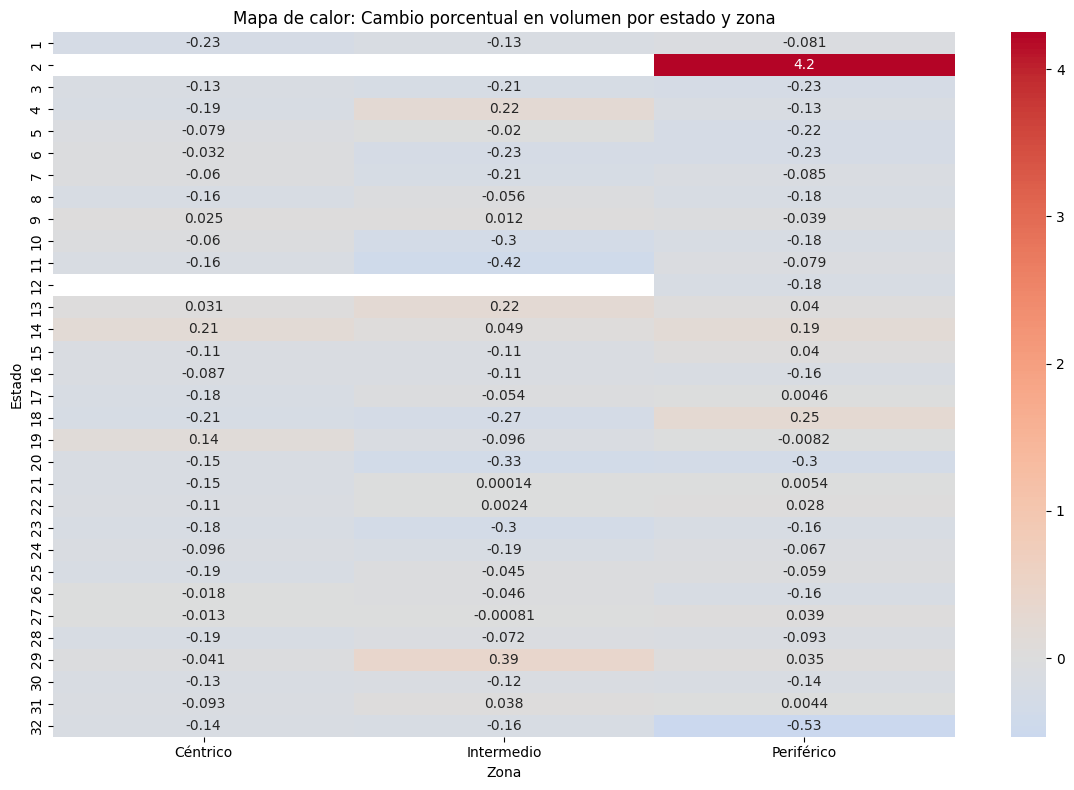

In [174]:
import seaborn as sns

pivot = df_resultados.pivot(index='state_id', columns='zona', values='pct_delta_vol')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, cmap='coolwarm', center=0)
plt.title('Mapa de calor: Cambio porcentual en volumen por estado y zona')
plt.ylabel('Estado')
plt.xlabel('Zona')
plt.tight_layout()
plt.show()

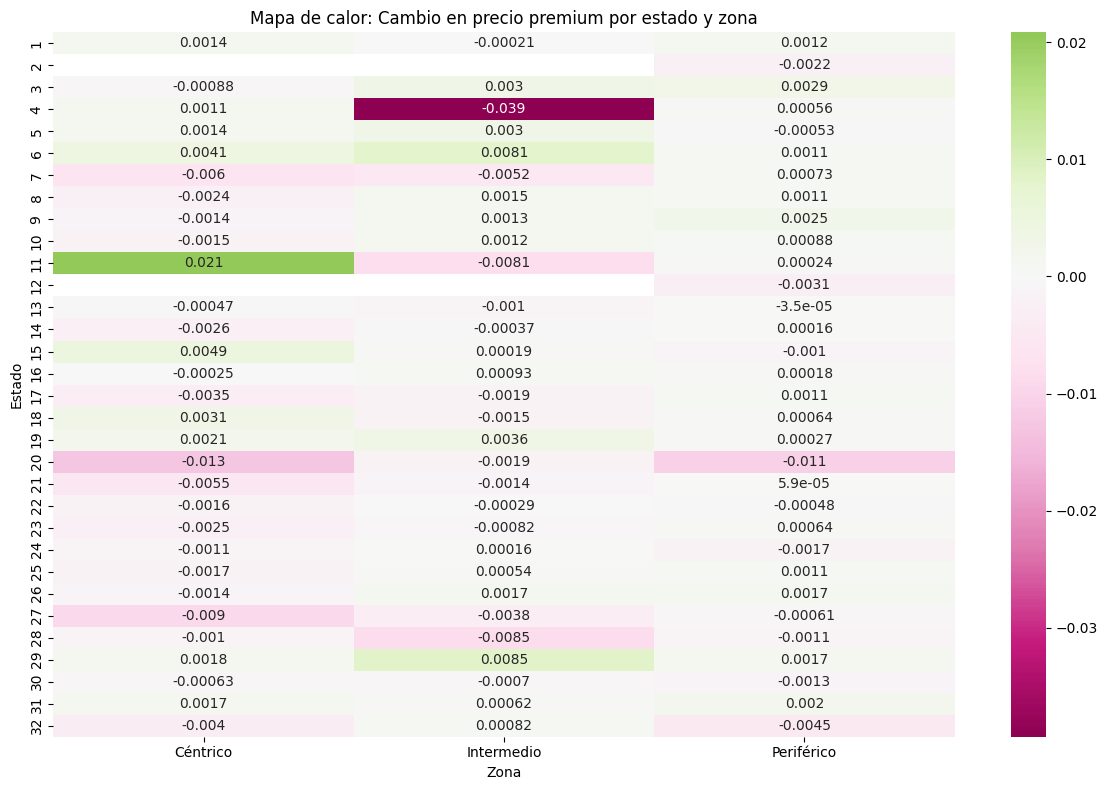

In [176]:
pivot_prem = df_resultados.pivot(index='state_id', columns='zona', values='delta_prem')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_prem, annot=True, cmap='PiYG', center=0)
plt.title('Mapa de calor: Cambio en precio premium por estado y zona')
plt.ylabel('Estado')
plt.xlabel('Zona')
plt.tight_layout()
plt.show()

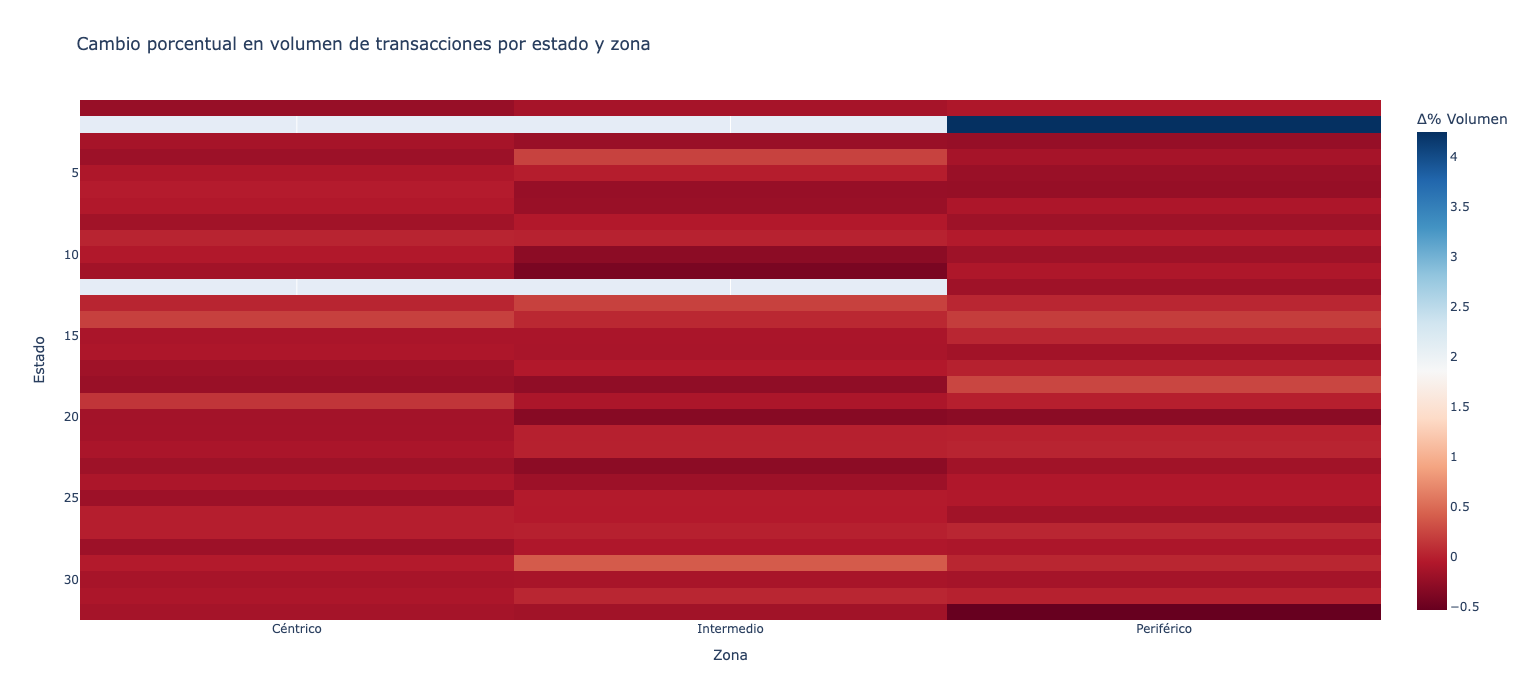

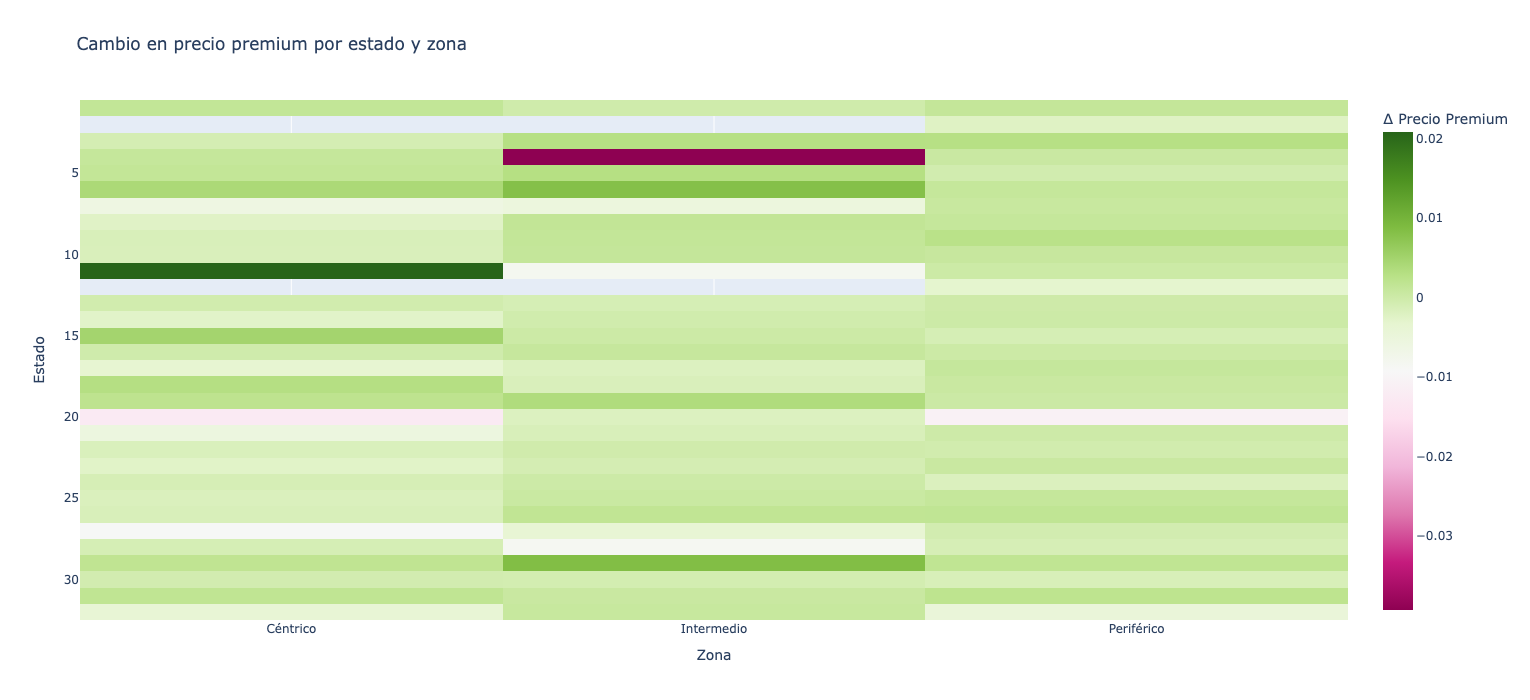

In [179]:
import plotly.express as px

# a) Heatmap de cambio porcentual en volumen por estado y zona
fig_vol = px.imshow(
    df_resultados.pivot(index='state_id', columns='zona', values='pct_delta_vol'),
    labels=dict(x="Zona", y="Estado", color="Δ% Volumen"),
    color_continuous_scale='RdBu',
    aspect='auto',
    title='Cambio porcentual en volumen de transacciones por estado y zona'
)
fig_vol.update_layout(height=700)
fig_vol.show()

# b) Heatmap de cambio en precio premium por estado y zona
fig_prem = px.imshow(
    df_resultados.pivot(index='state_id', columns='zona', values='delta_prem'),
    labels=dict(x="Zona", y="Estado", color="Δ Precio Premium"),
    color_continuous_scale='PiYG',
    aspect='auto',
    title='Cambio en precio premium por estado y zona'
)
fig_prem.update_layout(height=700)
fig_prem.show()


In [183]:
import folium

# Centra el mapa en México
m = folium.Map(location=[23.6345, -102.5528], zoom_start=5)

# Agrega coroplético
folium.Choropleth(
    geo_data=gdf_mex_states.to_json(),
    data=df_vol_estado,
    columns=['state_id', 'pct_delta_vol'],
    key_on='feature.properties.state_id',
    fill_color='RdBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Δ% Volumen'
).add_to(m)

# Agrega etiquetas emergentes
for _, row in gdf_mex_states.merge(df_vol_estado, on='state_id').iterrows():
    folium.Marker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        popup=f"{row['state_id']}: {row['pct_delta_vol']:.2%}"
    ).add_to(m)

m.save('mapa_interactivo_volumen.html')

In [185]:
for _, row in df_resultados.iterrows():
    print(f"{row['state_id']} - {row['zona']}:")
    print(f"  Cambio en volumen: {row['pct_delta_vol']:.2%} ({row['interpretacion_vol']})")
    print(f"  Cambio en precio premium: {row['delta_prem']:.2%} ({row['interpretacion_prem']})\n")

1 - Céntrico:
  Cambio en volumen: -22.89% (Fuerte caída en volumen tras COVID-19)
  Cambio en precio premium: 0.14% (Cambio menor en precio premium)

1 - Intermedio:
  Cambio en volumen: -13.00% (Cambio moderado o estable en volumen)
  Cambio en precio premium: -0.02% (Cambio menor en precio premium)

1 - Periférico:
  Cambio en volumen: -8.11% (Cambio moderado o estable en volumen)
  Cambio en precio premium: 0.12% (Cambio menor en precio premium)

2 - Periférico:
  Cambio en volumen: 424.99% (Recuperación o aumento en volumen tras COVID-19)
  Cambio en precio premium: -0.22% (Cambio menor en precio premium)

3 - Céntrico:
  Cambio en volumen: -13.16% (Cambio moderado o estable en volumen)
  Cambio en precio premium: -0.09% (Cambio menor en precio premium)

3 - Intermedio:
  Cambio en volumen: -21.32% (Fuerte caída en volumen tras COVID-19)
  Cambio en precio premium: 0.30% (Cambio menor en precio premium)

3 - Periférico:
  Cambio en volumen: -23.04% (Fuerte caída en volumen tras CO